In [1]:
# import os
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from eemeter.development.data import HourlyData
from itertools import combinations
# import time

# from hourly_test_utils import *
from applied_data_science.bigquery.data import Meter_Data
from eemeter import eemeter as em
# from eemeter.common.metrics import BaselineTestingMetrics as Metrics
from scipy.interpolate import RBFInterpolator

# import multiprocessing as mp

import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

In [2]:
#load subsamples from the main MCE dataset
dataset = 'mce'
subsample = 1
has_solar = True

cache_dir = Path("/app/.recurve_cache/data").resolve()

if 'data' in globals():
    del data

data = Meter_Data(dataset, subsample, "hourly", solar=has_solar, cache_dir=cache_dir)
meta = data.df['meta']
subsample_df = data.df['meter']
ids = subsample_df.index.unique()

Loading: /app/.recurve_cache/data/MCE/MCE_covid_solar_meta_1.pkl
Done in 0.008 s
Loading: /app/.recurve_cache/data/MCE/MCE_covid_solar_hourly_meter_1.pkl
Done in 6.272 s


In [3]:
lowest_mean = 0
for id_index, id in enumerate(ids):
    meter_id = id
    meter = subsample_df.loc[meter_id].copy()
    meter_baseline = meter.loc[meter['period'] == 'baseline'].copy()

    mn = meter_baseline['observed'].mean()

    if mn > lowest_mean:
        lowest_mean = mn
        lowest_meter = meter_id
        min_idx = id_index
print(f"Lowest mean: {lowest_mean}")
print(f"Lowest meter: {lowest_meter}")
print("Min ID: ", min_idx)
meter = subsample_df.loc[lowest_meter].copy()
meter_baseline = meter.loc[meter['period'] == 'baseline'].copy()
meter_reporting = meter.loc[meter['period'] == 'reporting'].copy()

Lowest mean: 194.48479217715348
Lowest meter: None-9097391784_1-9097391784_1
Min ID:  970


In [4]:
alpha_opt = 0.15
l1_ratio_opt = 0.05
settings = em.HourlySettings(
    TRAIN_FEATURES=['ghi'],
    LAGGED_FEATURES=None, # 'ghi'
    WINDOW=None,
    SUPPLEMENTAL_DATA=None,
    # SUPPLEMENTAL_DATA=['solar_supp'],
    ALPHA=alpha_opt,
    L1_RATIO=l1_ratio_opt,
    SELECTION="cyclic",
    MAX_ITER=1000,
    SEED=42
)

In [5]:
# get one meter
meter_id = ids[55]
meter = subsample_df.loc[meter_id].copy()
# PV_interventation = "2019-11-09"
PV_interventation = "2021-01-21"

#change PV_interventation to datetime
PV_interventation = pd.to_datetime(PV_interventation)
meter['solar_supp'] = 0
meter.loc[meter['date'] >= PV_interventation.date(), 'solar_supp'] = 1

# select baseline period
meter_baseline = meter.loc[meter['period'] == 'baseline'].copy()

meta_meter = meta.loc[meter_id]

# get unique pair of station_latitude and station_longitude
unique_pairs = meta_meter[['station_latitude', 'station_longitude']].drop_duplicates()

# print unique pairs
METADATA = {
    'station_latitude': unique_pairs['station_latitude'].values[0],
    'station_longitude': unique_pairs['station_longitude'].values[0],
}

#TODO: keep it simple and let the input force the output
OUTPUT_FEATURES=['temperature', 'observed', 'model', 'solar_supp']
if 'ghi' in settings.TRAIN_FEATURES:
    CONSIDER_SOLAR = True
    OUTPUT_FEATURES.append('ghi')
    OUTPUT_FEATURES.append('clearsky_ghi')
else:
    CONSIDER_SOLAR = False
kwargs = {
    'solar': CONSIDER_SOLAR,
    'metadata': METADATA,
    'outputs': OUTPUT_FEATURES,
}
data_baseline = HourlyData(meter_baseline, **kwargs)

In [6]:
model = em.HourlyModel(settings)
model.fit(data_baseline)
pred_baseline = model.predict(data_baseline)


## Interpolation analysis

In [7]:
#remove random time slots for temperature and make them nan
np.random.seed = 27
random_slots = np.random.choice(meter_baseline['datetime'], 150, replace=False)
meter_baseline_nans = meter_baseline.copy()
# interpolation_columns = ['temperature', 'observed']
interpolation_columns = ['temperature']

for col in interpolation_columns:
    meter_baseline_nans.loc[meter_baseline_nans['datetime'].isin(random_slots), col] = np.nan
print(meter_baseline_nans['temperature'].isna().sum())
print(meter_baseline_nans['observed'].isna().sum())

150
71


In [8]:
# interpolation_col_helper = {}
# for lag in [1, 7]:
#     # shift lag days for both temp and observed and make acolumn for each
#     for col in ['temperature', 'observed']:
#         if not col in interpolation_col_helper:
#             interpolation_col_helper[col] = []

#         helper_col = f'day_{col}_lag_{lag}'
#         interpolation_col_helper[col].append(helper_col)
#         meter_baseline_nans[f'day_{col}_lag_{lag}'] = meter_baseline_nans[col].shift(24*lag)


# interpolation_col_helper

In [9]:
# #interpolate for each main col based on helpers
# col_helper_vec = {}
# target_helper_vec = {}
# interpolators = {}
# for col in ['temperature', 'observed']:
#     helper_cols = interpolation_col_helper[col]
#     df_temp = meter_baseline_nans.copy()
#     col_helper_vec[col] = df_temp.dropna(subset=helper_cols)
#     normal_datetimes = col_helper_vec[col]['start_local']
#     col_helper_vec[col] = col_helper_vec[col][helper_cols].values
#     noise = np.random.standard_normal(col_helper_vec[col].shape)
#     col_helper_vec[col]+=noise
#     target_helper_vec[col] = df_temp.loc[df_temp['start_local'].isin(normal_datetimes)][col]

#     interp = RBFInterpolator(col_helper_vec[col], target_helper_vec[col])
#     # preds = interp(temp_vector_nans)


In [10]:
def check_datetime(df):
    #get all the columns with datetime type #TODO: check if this is the best way to do this
    datetime_columns = df.select_dtypes(include=[np.datetime64]).columns
    # check if datetime is in the columns
    if "datetime" in df.columns:
        pass
    elif "datetime" in df.index.names:
        df['datetime'] = df.index
        df = df.reset_index(drop=True)
    elif "start_local" in df.columns:
        df['datetime'] = df['start_local']
        df = df.drop(columns=["start_local"])
    elif len(datetime_columns) > 0:
        df['datetime'] = df[datetime_columns[0]]
        df = df.drop(columns=[datetime_columns[0]])
    else:
        raise ValueError("datetime column not found")
    
    #reset index to ensure datetime is not the index
    df = df.reset_index()
    return df

def get_contiguous_datetime(df):
    # get earliest datetime and latest datetime
    # make earliest start at 0 and latest end at 23, this ensures full days
    earliest_datetime = df["datetime"].min().replace(hour=0, minute=0, second=0, microsecond=0)
    latest_datetime = df["datetime"].max().replace(hour=23, minute=0, second=0, microsecond=0)

    # create a new index with all the hours between the earliest and latest datetime
    complete_dt = pd.date_range(start=earliest_datetime, end=latest_datetime, freq='H').to_frame(index=False, name="datetime")

    # merge meter data with complete_dt
    df = complete_dt.merge(df, on="datetime", how="left")
    df['date'] = df['datetime'].dt.date
    df['hour_of_day'] = df['datetime'].dt.hour

    return df

def remove_duplicate_datetime(df):
    if "observed" in df.columns:
        # find duplicate datetime values and remove if nan
        duplicate_dt_mask = df.duplicated(subset="datetime", keep=False)
        observed_nan_mask = df['observed'].isna()
        df = df[~(duplicate_dt_mask & observed_nan_mask)]

        # if duplicated and observed is not nan, keep the largest abs(value)
        df["abs_observed"] = df["observed"].abs()
        df = df.sort_values(by=["datetime", "abs_observed"], ascending=[True, False])
        df = df.drop_duplicates(subset="datetime", keep="first")
        df = df.drop(columns=["abs_observed"])

    else:
        # TODO what if there is no observed column? Could have dup datetime with different temperatures
        df = df.drop_duplicates(subset="datetime", keep="first")

    return df

In [11]:
print(meter_baseline_nans.shape)
meter_baseline_nans = check_datetime(meter_baseline_nans)
meter_baseline_nans = get_contiguous_datetime(meter_baseline_nans)
meter_baseline_nans = remove_duplicate_datetime(meter_baseline_nans)
print(meter_baseline_nans.shape)


(8760, 17)
(8760, 18)


In [34]:
class Interpolator:
    def __init__(self, df, columns=['temperature', 'observed'], grid_lag_lead_days = [-7, -1, 1, 7]):
        self.df = df
        self.columns = columns
        self.grid_lag_lead_days = grid_lag_lead_days
        self.intrp = RBFInterpolator

    def interpolate(self):
        # Main method to perform the interpolation
        for col in self.columns:
            self._col_interpolation(col)
        return self.df
    
    def _col_interpolation(self, col):
        # Method to interpolate a single column
        column_df = self.df[['datetime', 'date', col]]
        # add lag and lead columns
        interp_helper_cols = []
        for shift in self.grid_lag_lead_days:
            column_df[f'{col}_day_({shift})'] = column_df[col].shift(shift*24)
            interp_helper_cols.append(f'{col}_day_({shift})')

        column_df['hour_of_day'] = column_df['datetime'].dt.hour
        #group by date
        column_df = column_df.groupby('date')
        # interpolate each day
        c=0
        for date, group in column_df:
            nans = group[group[col].isna()]

            
            if nans.empty:
                continue
            print(date)
            normal_datapoints = group[~group[col].isna()]
            nans_dt = nans['datetime'].values
            normal_dt = normal_datapoints['datetime'].values

            #check the viable solutions for nans and normal points
            sorted_sets = {}
            for category in ['nans', 'normal']:
                dt_idx = nans_dt
                if category=='normal':
                    dt_idx = normal_dt
                helper_matrix = group.loc[group['datetime'].isin(dt_idx)]
                helper_matrix_mask = 1 - helper_matrix[interp_helper_cols].isna().astype(int)

                columns = helper_matrix_mask.columns.tolist()
                combinations_list = []
                for r in range(0, len(columns) + 1):
                    combinations_list.extend(combinations(columns, r))
                combinations_list = sorted(combinations_list, key=len, reverse=True)

                helper_matrix_mask['pointer'] = helper_matrix_mask.apply(lambda row: ' '.join(row.astype(str)), axis=1)
                helper_matrix_mask['class'] = helper_matrix_mask[columns].sum(axis=1)
                helper_matrix_mask['datetime'] = helper_matrix['datetime']
                datetime_lists = helper_matrix_mask.groupby('pointer')['datetime'].apply(list).to_dict()
                
                helper_matrix_mask_sorted = helper_matrix_mask.groupby(['class', 'pointer']).size().reset_index(name='counts')
                helper_matrix_mask_sorted = helper_matrix_mask_sorted.sort_values(by=['class', 'counts'], ascending=[False, False])
                helper_matrix_mask_sorted[f'datetime_lists_{category}'] = helper_matrix_mask_sorted['pointer'].map(datetime_lists)
                
                sorted_sets[category] = helper_matrix_mask_sorted
            
            #match each nans item/s with it's similar normal data
            grouped_nans = sorted_sets['nans']
            grouped_normal = sorted_sets['normal']
            
            matched_nans = pd.merge(grouped_nans, grouped_normal, on='pointer', how='left')
            print(matched_nans)

            for pointer in matched_nans['pointer']:
                nans_dt = matched_nans.loc[matched_nans['pointer'] == pointer]['datetime_lists_nans'].values[0]
                normal_dt = matched_nans.loc[matched_nans['pointer'] == pointer]['datetime_lists_normal'].values[0]

                #pointer to interp_helper_cols map
                pointer_map = dict(zip(interp_helper_cols, pointer.split()))
                selected_interp_helper_cols = [k for k, v in pointer_map.items() if v=='1']

                interp_points = group.loc[group['datetime'].isin(normal_dt)][selected_interp_helper_cols].values
                interp_values = group.loc[group['datetime'].isin(normal_dt)][col].values

                nan_points = group.loc[group['datetime'].isin(nans_dt)][selected_interp_helper_cols].values
                pred = self._interpolate_day(interp_points, interp_values, nan_points)
                print(pred)


            c+=1
            if c>10:
                break

            # dropna if a row has a nan
            
            # points = group['hour_of_day'].values
            # values = group[col].values
            
            # pred = self._interpolate_day(points, values, nans)
            # column_df.loc[column_df['date'] == date, col] = pred


        return column_df
        
    def _interpolate_day(self, points, values, nans):
        # Method to interpolate a single day
        if len(values)==0:
            return np.nan
        
        interp = self.intrp(points, values)
        pred = interp(nans)
        return pred



In [35]:
interpolator = Interpolator(meter_baseline_nans)
col = 'temperature'
df_interpolated = interpolator._col_interpolation(col)

2019-03-07
   class_x  pointer  counts_x                         datetime_lists_nans  \
0        3  1 1 1 0         2  [2019-03-07 09:00:00, 2019-03-07 18:00:00]   

   class_y  counts_y                              datetime_lists_normal  
0        3        21  [2019-03-07 00:00:00, 2019-03-07 01:00:00, 201...  
[52.11031508 51.1266803 ]
2019-03-09
   class_x  pointer  counts_x    datetime_lists_nans  class_y  counts_y  \
0        4  1 1 1 1         1  [2019-03-09 22:00:00]        4        20   

                               datetime_lists_normal  
0  [2019-03-09 00:00:00, 2019-03-09 01:00:00, 201...  
[48.60436481]
2019-03-10
   class_x  pointer  counts_x  \
0        4  1 1 1 1         3   

                                 datetime_lists_nans  class_y  counts_y  \
0  [2019-03-10 02:00:00, 2019-03-10 09:00:00, 201...        4        20   

                               datetime_lists_normal  
0  [2019-03-10 00:00:00, 2019-03-10 01:00:00, 201...  
[48.00028145 49.72346527 51.7093506

TypeError: only list-like objects are allowed to be passed to isin(), you passed a `float`

In [194]:
df_interpolated['g'] = np.nan
df_interpolated.dropna()

TypeError: 'DataFrameGroupBy' object does not support item assignment

In [83]:
a = np.array([[1,0], [1, 1], [0, 0]])
str(a)

'[[1 0]\n [1 1]\n [0 0]]'

In [54]:
#matrix rank
a = np.array([[1,0], [1, 1], [0, 0]])
np.linalg.matrix_rank(a)

#binary sum of each row
a = np.array([[1,0], [1, 1], [1, 1]])
if 2 in np.sum(a, axis=1):
    print(np.sum(a, axis=1))

[1 2 2]


In [61]:
b = pd.DataFrame(a)

b.loc[b.sum(axis=1)==1]

0  1
0  1  0

In [131]:
from itertools import combinations
# make a dummy helper_matrix
cols = ['a', 'b', 'c']
helper_matrix = pd.DataFrame(np.array([[1,1, 1],[1,1, 1],[1,1, 1],[1,1, 1], [1,0, 1], [1,0, 1],[1,0, 1],[1,0, 1],[1,0, 1], [0, 0, 0], [1, 1, 0],[1, 1, 0],[1, 1, 0]]), columns=cols)
columns = helper_matrix.columns.tolist()
combinations_list = []

for r in range(0, len(columns) + 1):
    combinations_list.extend(combinations(columns, r))
#order the combinations_list
combinations_list = sorted(combinations_list, key=len, reverse=True)

# Print combinations
# for combo in combinations_list:
#     print(helper_matrix[list(combo)])


vector = helper_matrix.apply(lambda row: ' '.join(row.astype(str)), axis=1)
helper_matrix['pointer'] = vector
helper_matrix['class'] = helper_matrix[cols].sum(axis=1)
helper_matrix_sorted = helper_matrix.groupby(['class', 'pointer']).size().reset_index(name='counts')
helper_matrix_sorted = helper_matrix_sorted.sort_values(by=['class', 'counts'], ascending=[False, False])

helper_matrix_sorted



class pointer  counts
3      3   1 1 1       4
1      2   1 0 1       5
2      2   1 1 0       3
0      0   0 0 0       1

In [140]:
helper_matrix.loc[helper_matrix['pointer'] == helper_matrix_sorted.iloc[0]['pointer']]

a  b  c pointer  class
0  1  1  1   1 1 1      3
1  1  1  1   1 1 1      3
2  1  1  1   1 1 1      3
3  1  1  1   1 1 1      3

In [119]:
sorted_vector = helper_matrix[['class', 'pointer']].value_counts().sort_index(ascending=False)
sorted_vector

class  pointer
3      1 1 1      7
2      1 1 0      3
       1 0 1      5
0      0 0 0      1
Name: count, dtype: int64

class pointer  counts
3      3   1 1 1       7
1      2   1 0 1       5
2      2   1 1 0       3
0      0   0 0 0       1

2019-03-09
temperature


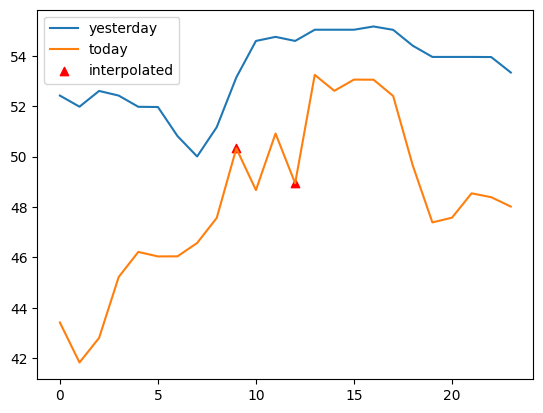

2019-03-12
temperature


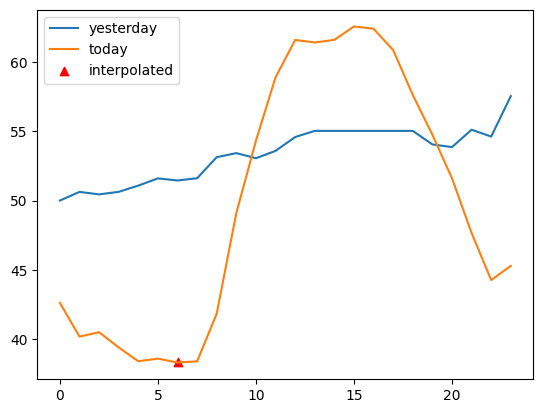

2019-03-21
temperature


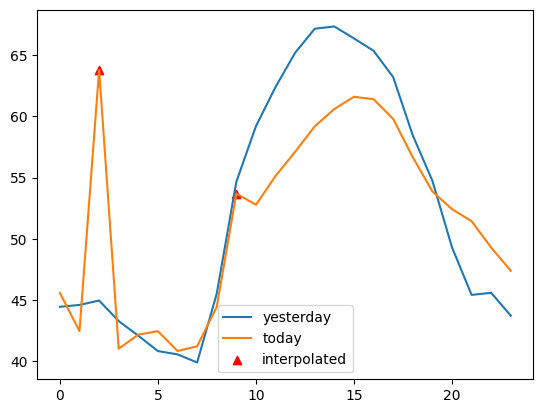

2019-03-22
temperature


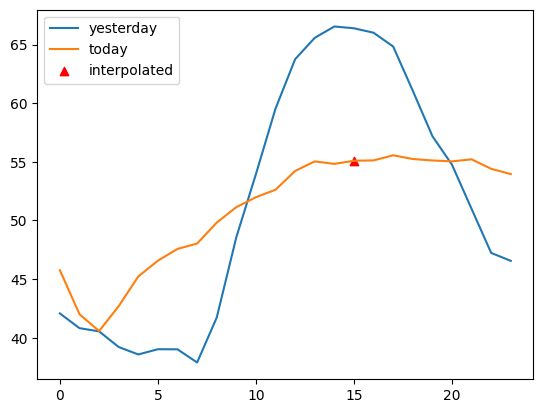

2019-03-29
temperature


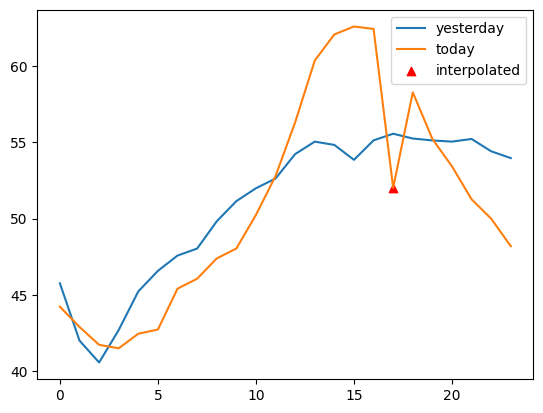

2019-03-31
temperature


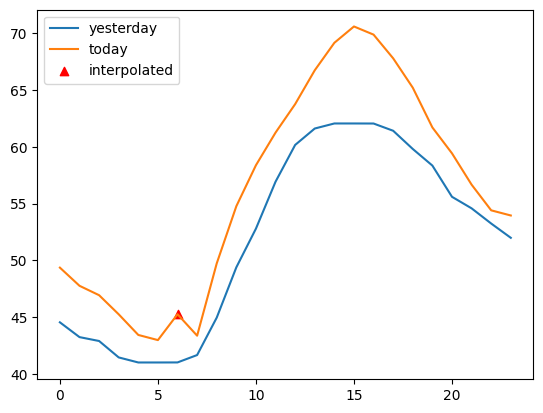

2019-04-01
temperature


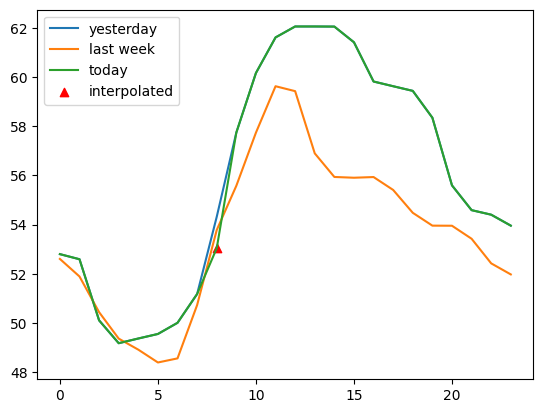

2019-04-05
temperature


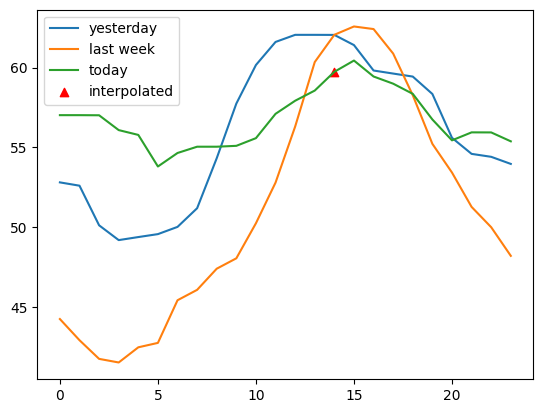

2019-04-07
temperature


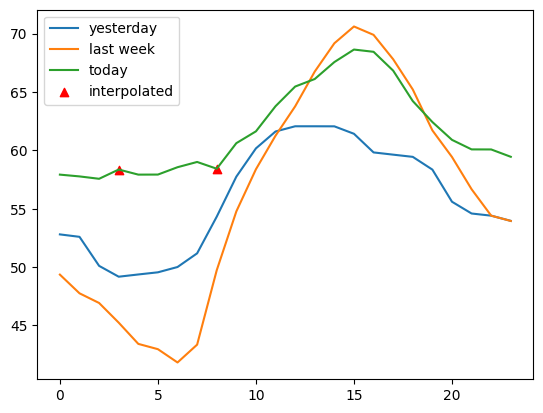

2019-04-10
temperature


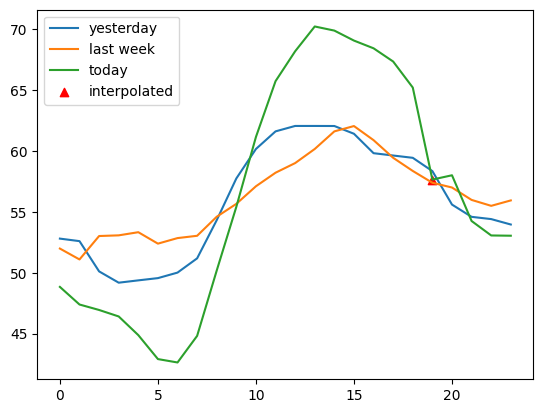

2019-04-19
temperature


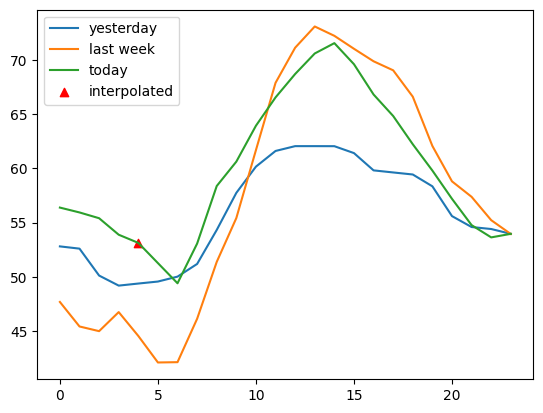

2019-04-22
temperature


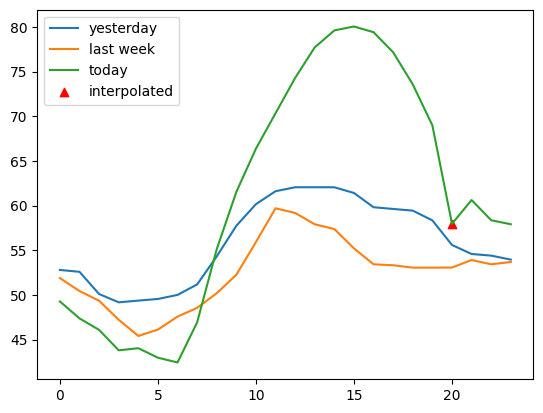

2019-04-24
temperature


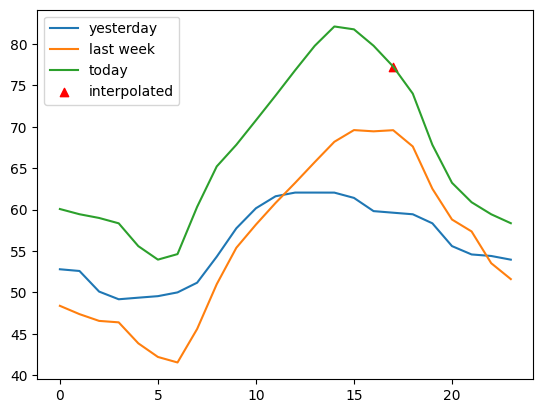

2019-04-26
temperature


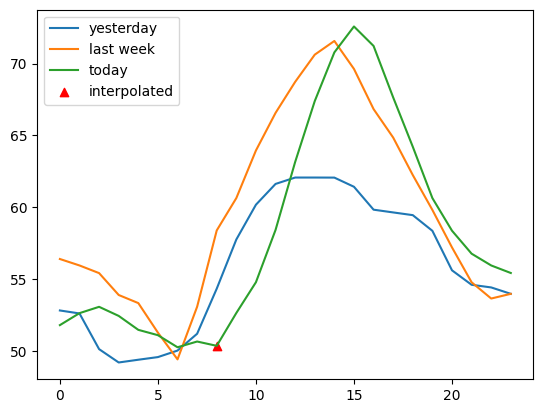

2019-04-28
temperature


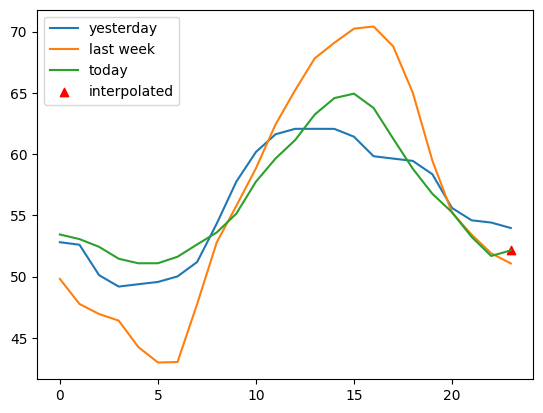

2019-04-30
temperature


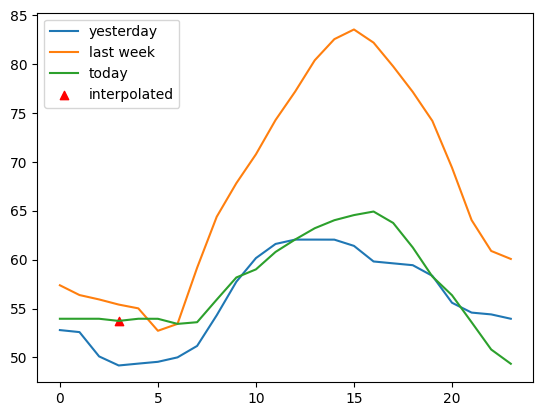

2019-05-01
temperature


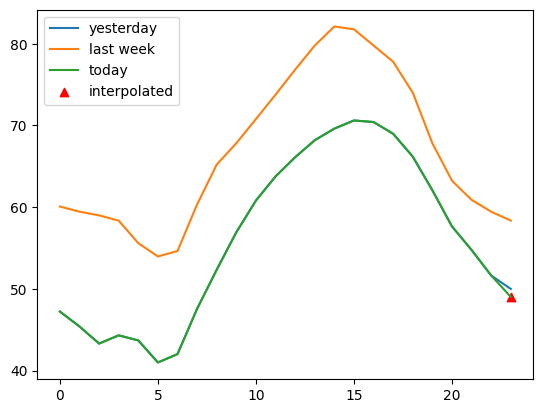

2019-05-02
temperature


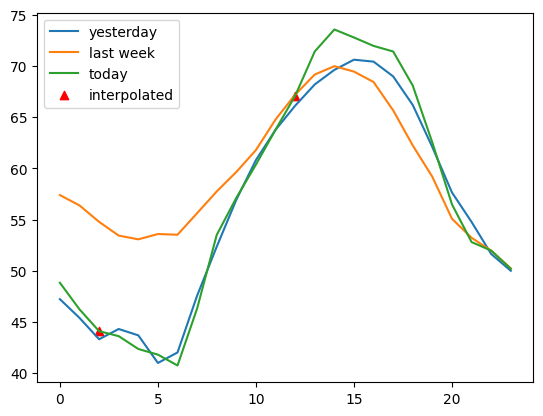

2019-05-03
temperature


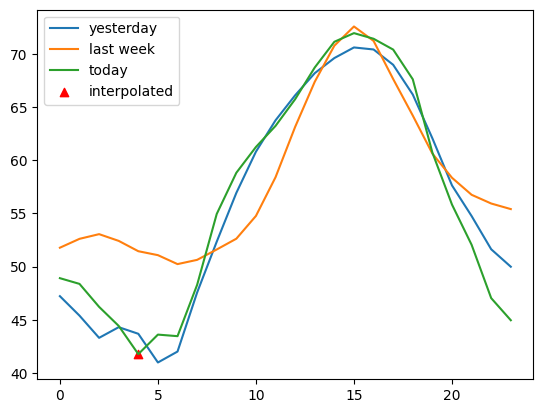

2019-05-08
temperature


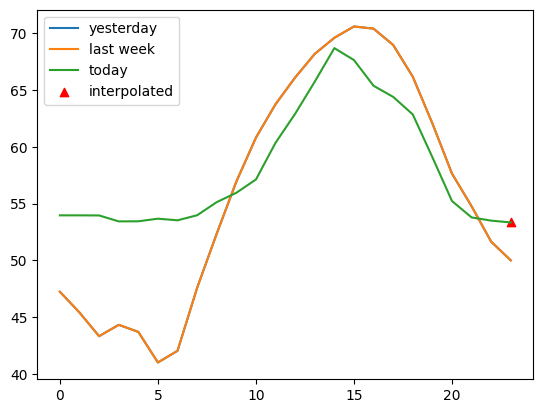

2019-05-09
temperature


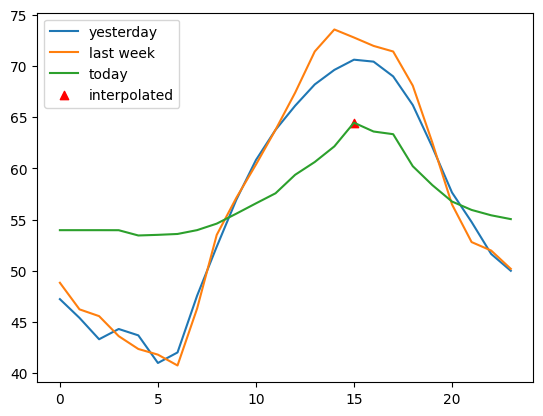

2019-05-12
temperature


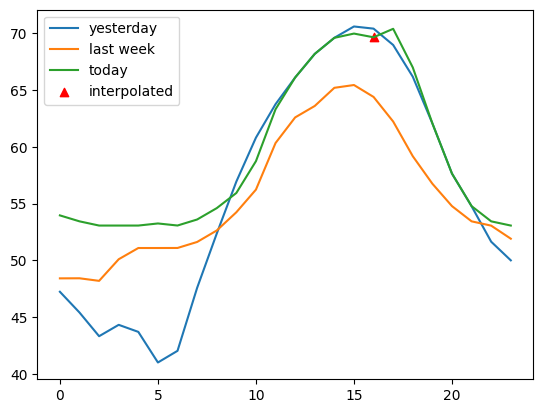

2019-05-13
temperature


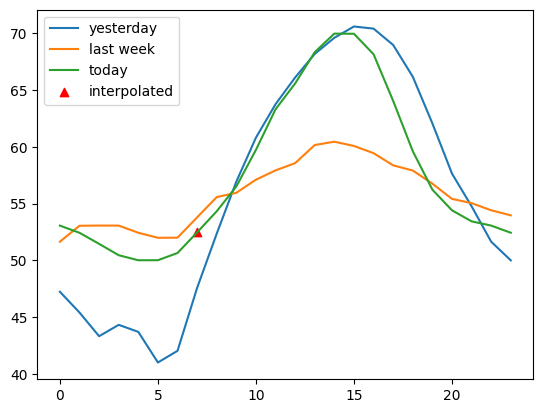

2019-05-14
temperature


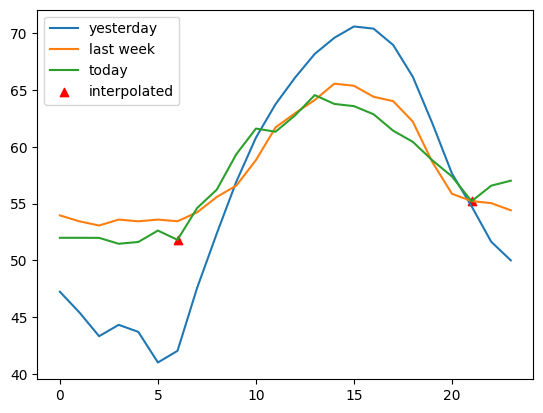

2019-05-19
temperature


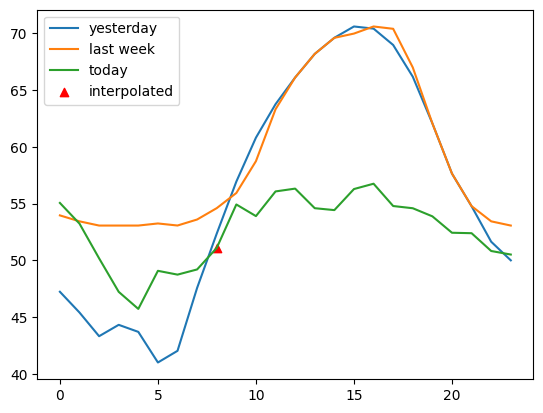

2019-05-24
temperature


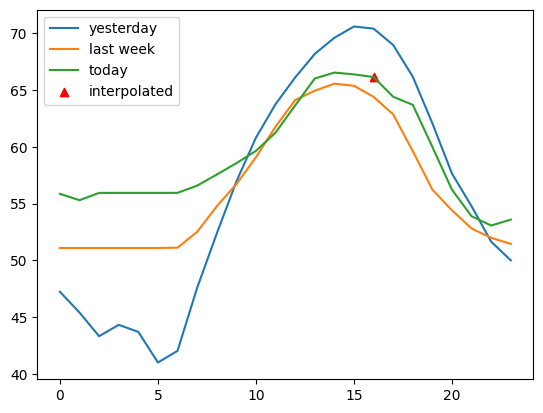

2019-05-26
temperature


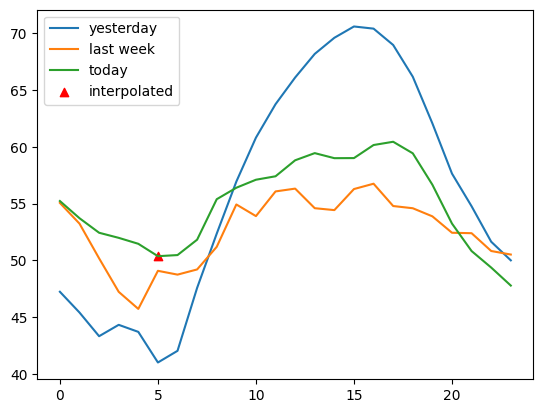

2019-05-29
temperature


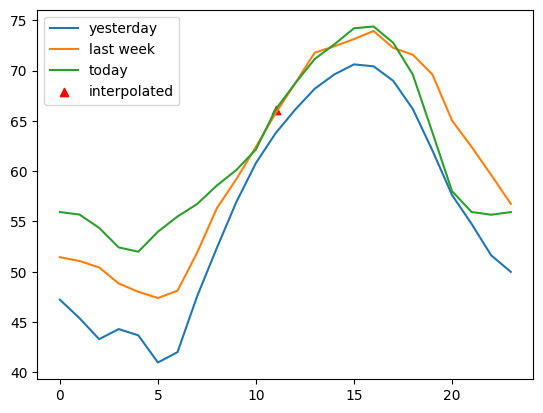

2019-05-31
temperature


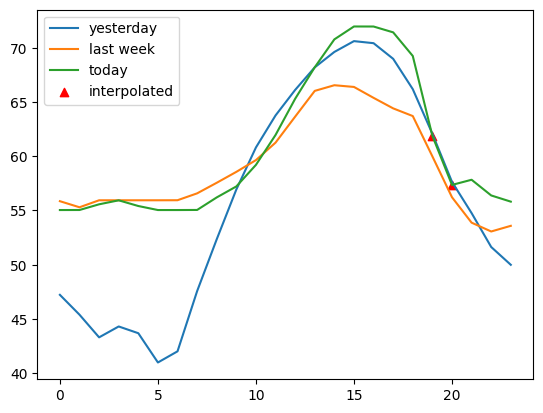

2019-06-12
temperature


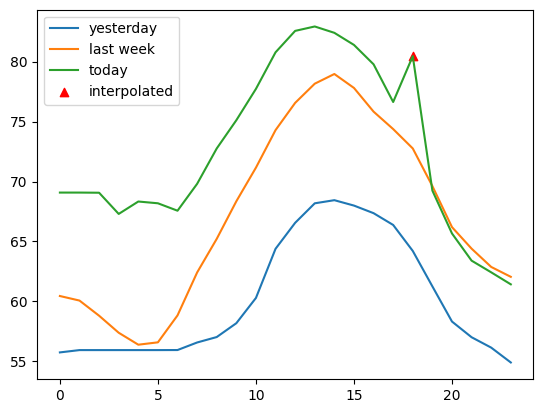

2019-06-13
temperature


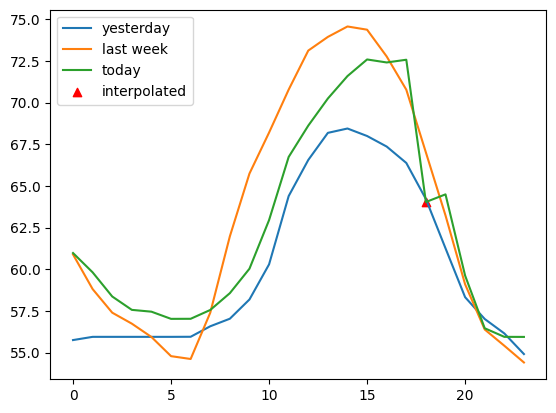

2019-06-14
temperature


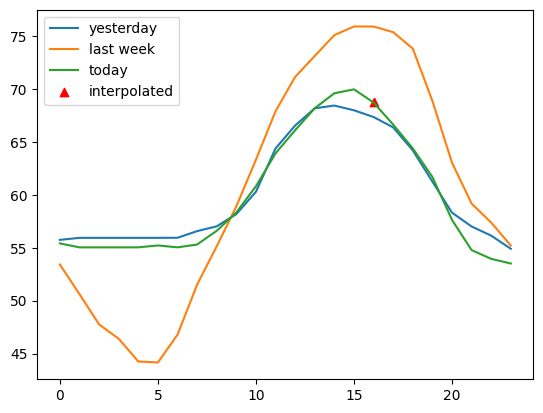

2019-06-15
temperature


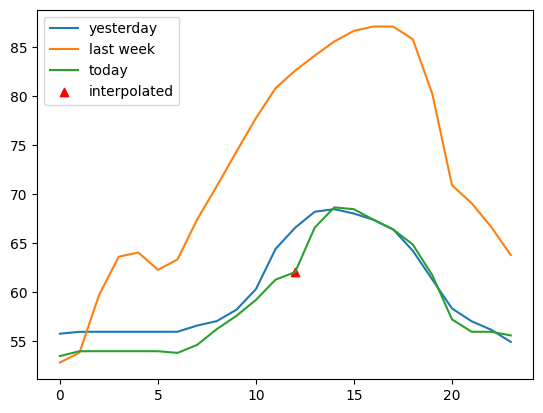

2019-06-18
temperature


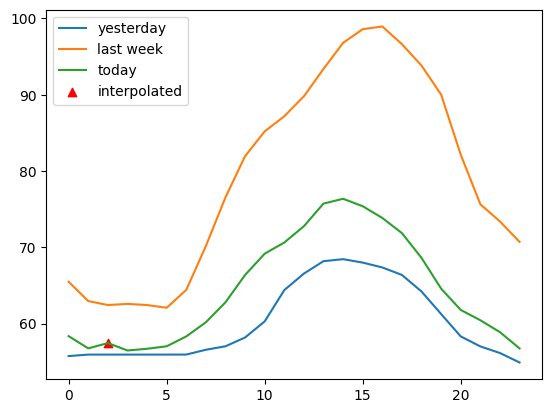

2019-06-20
temperature


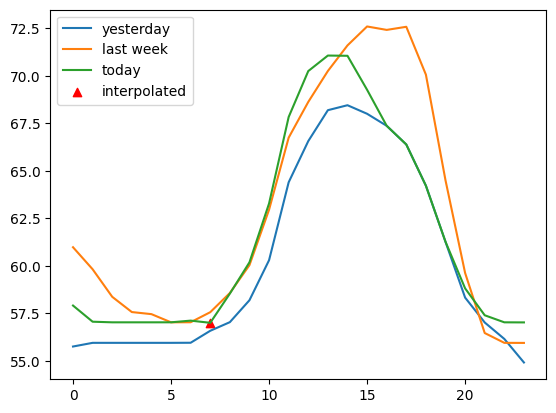

2019-06-21
temperature


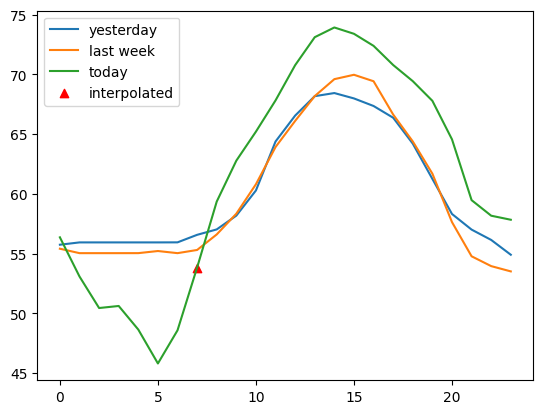

2019-06-22
temperature


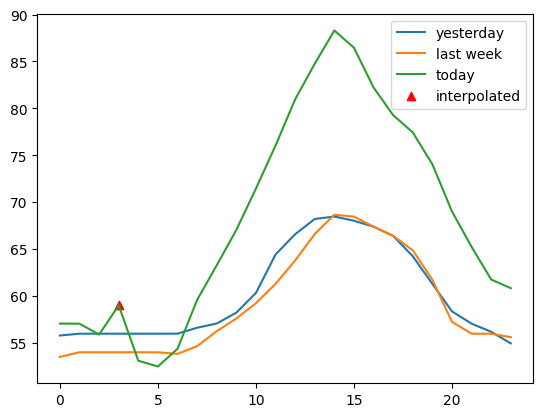

2019-06-23
temperature


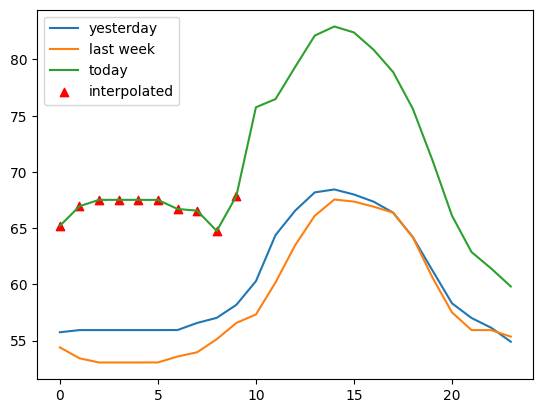

2019-06-24
temperature


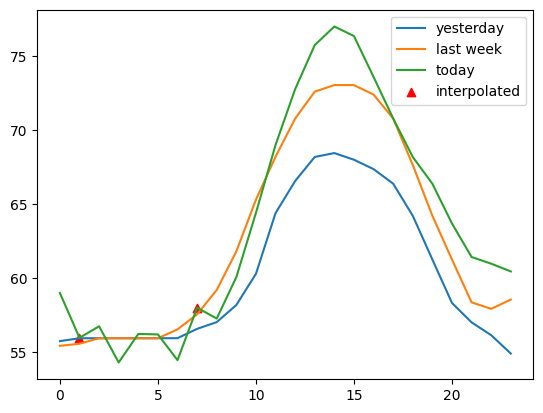

2019-07-07
temperature


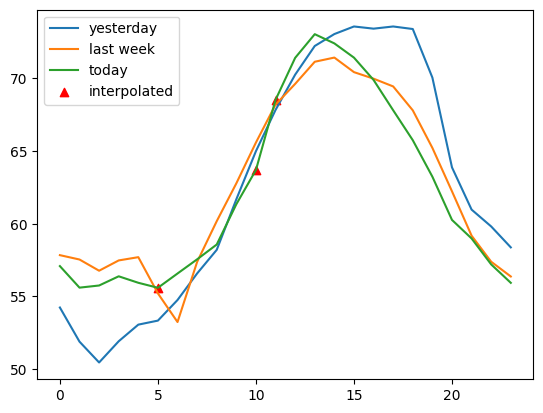

2019-07-08
temperature


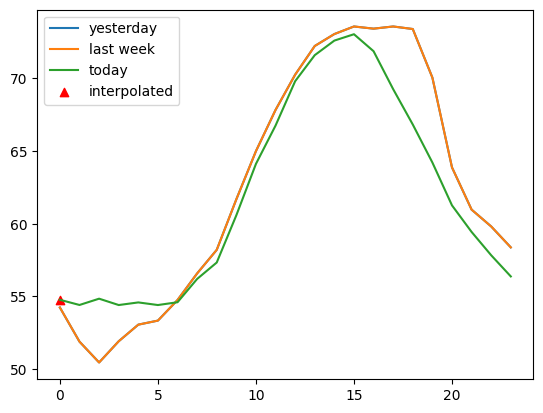

2019-07-10
temperature


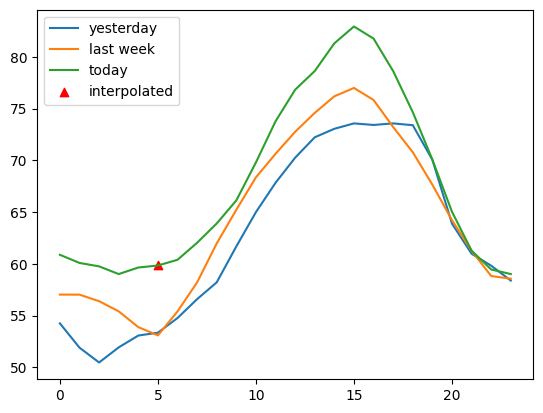

2019-07-14
temperature


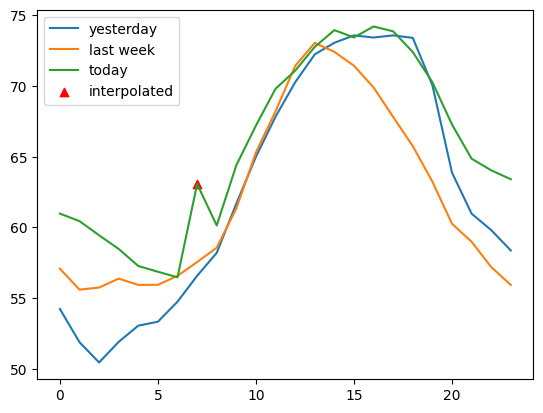

2019-07-16
temperature


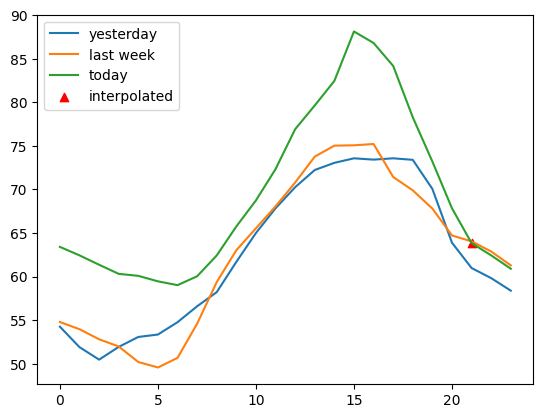

2019-07-17
temperature


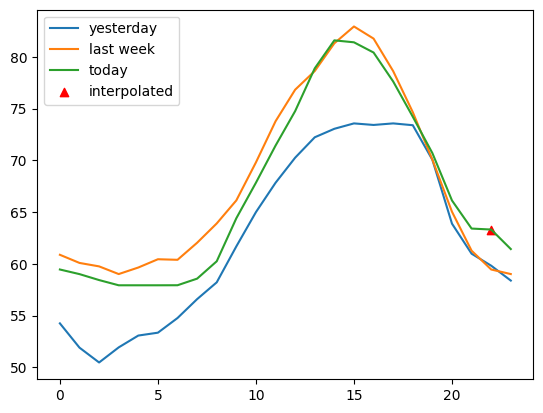

2019-07-20
temperature


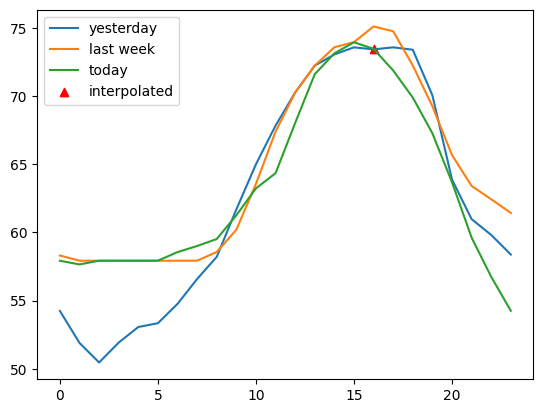

2019-07-27
temperature


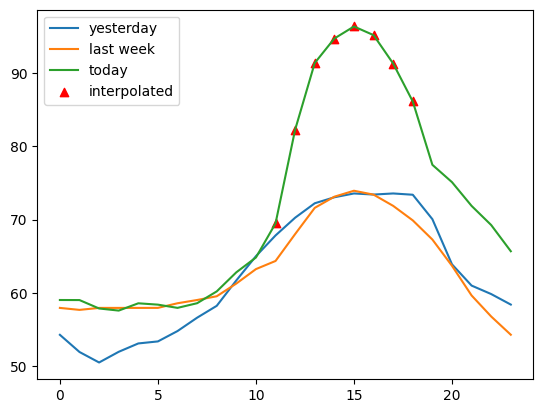

2019-07-28
temperature


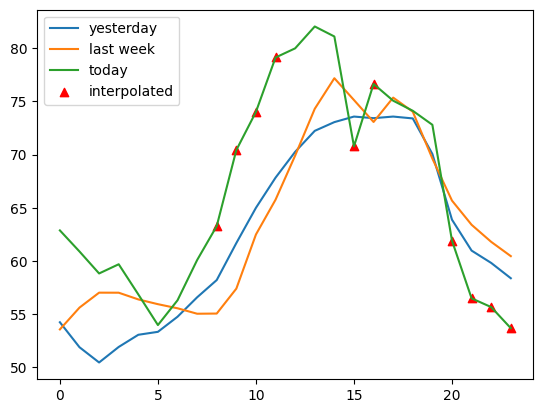

2019-07-29
temperature


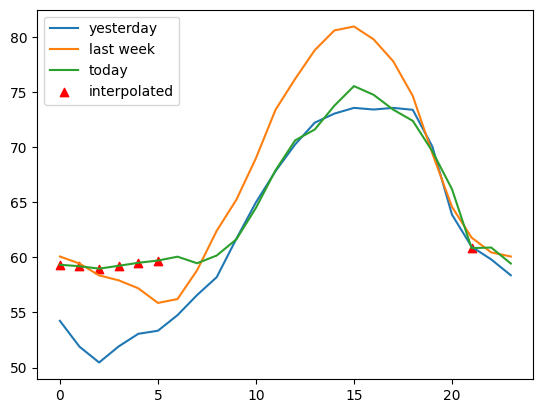

2019-07-30
temperature


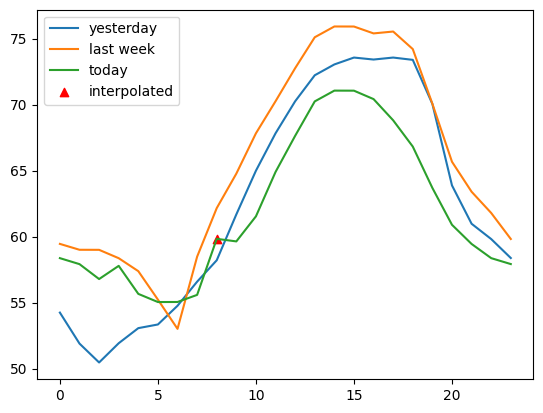

2019-07-31
temperature


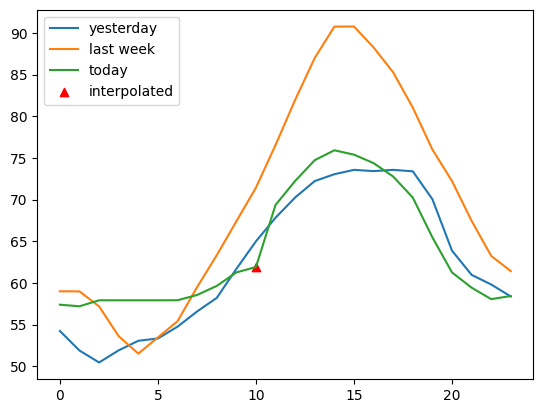

2019-08-01
temperature


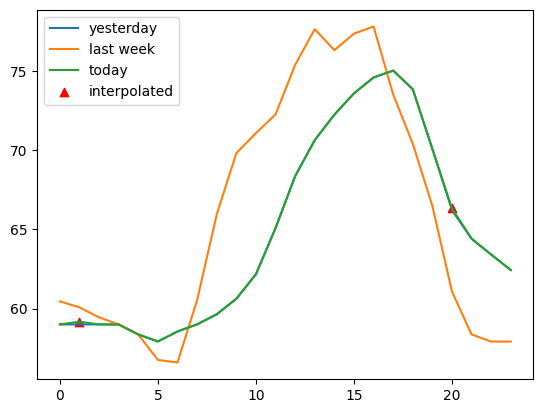

2019-08-07
temperature


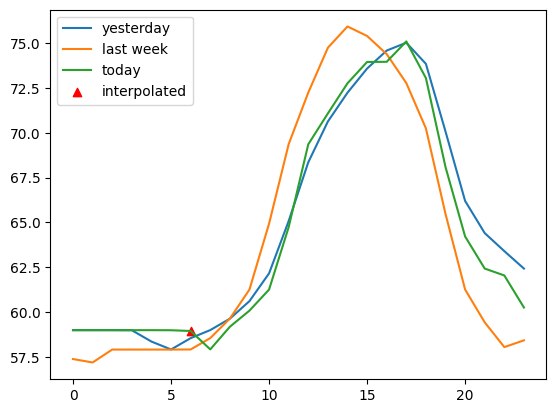

2019-08-18
temperature


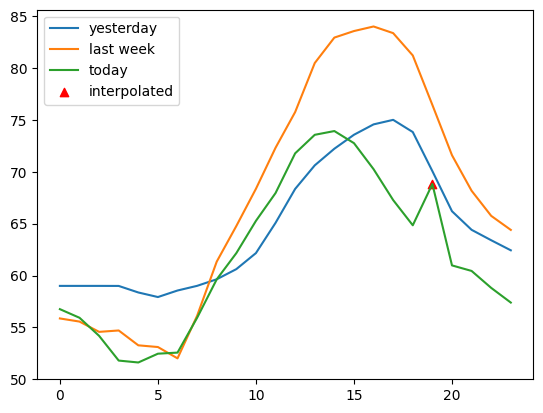

2019-08-21
temperature


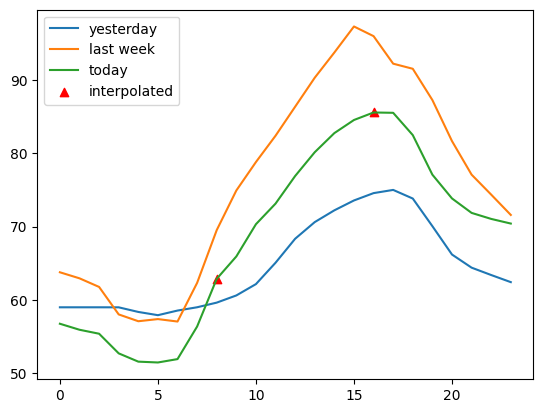

2019-08-22
temperature


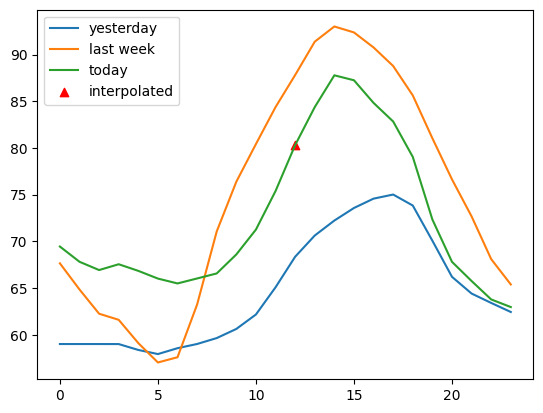

2019-08-28
temperature


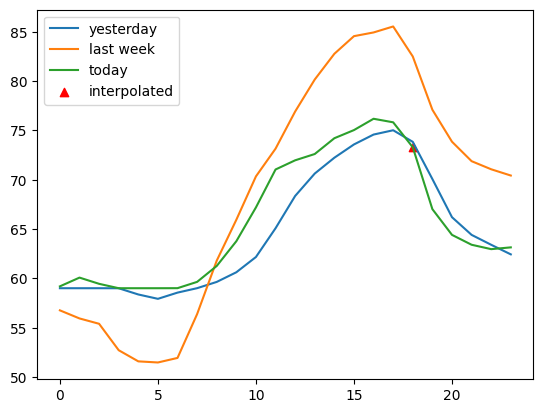

2019-08-30
temperature


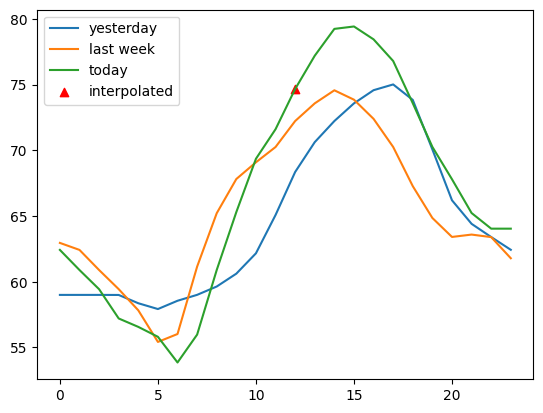

2019-08-31
temperature


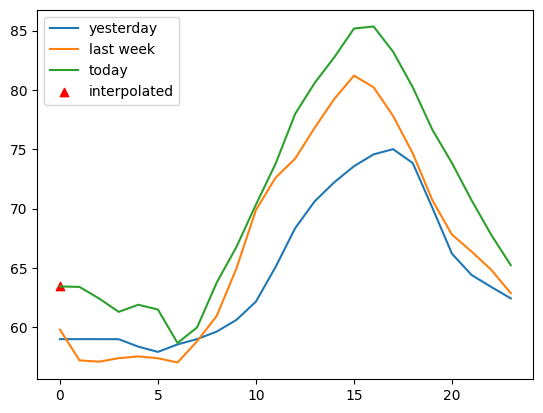

2019-09-03
temperature


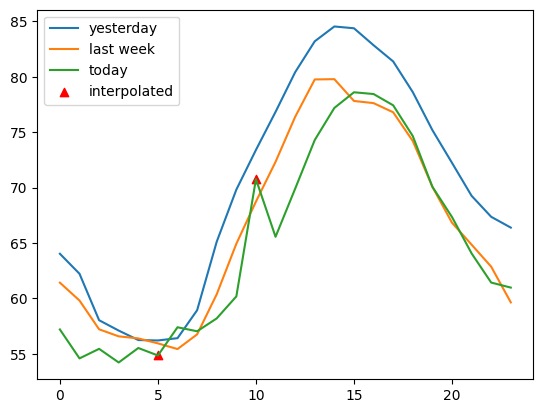

2019-09-06
temperature


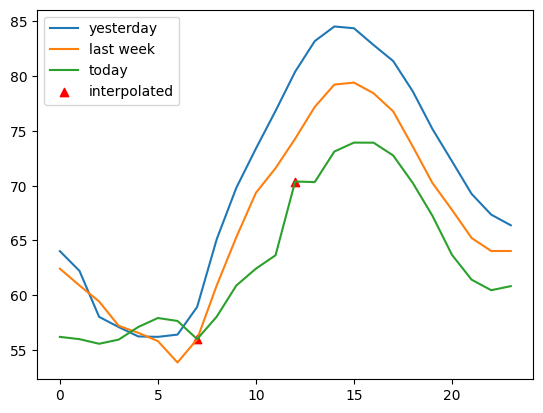

2019-09-07
temperature


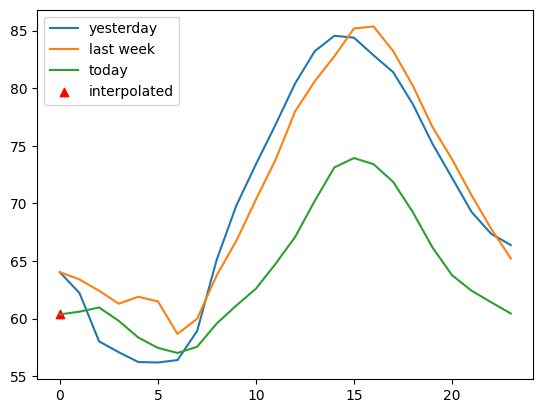

2019-09-08
temperature


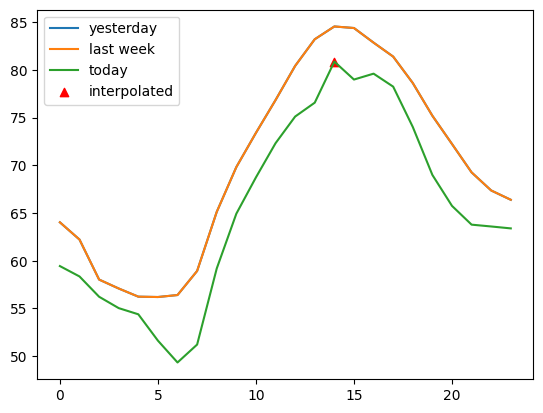

2019-09-15
temperature


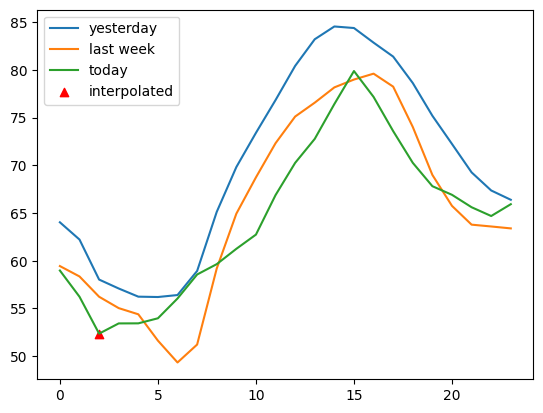

2019-09-29
temperature


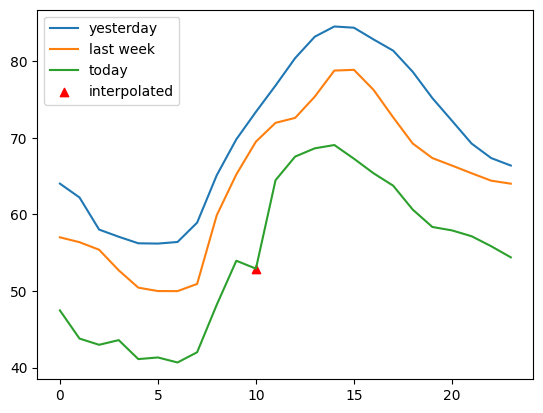

2019-09-30
temperature


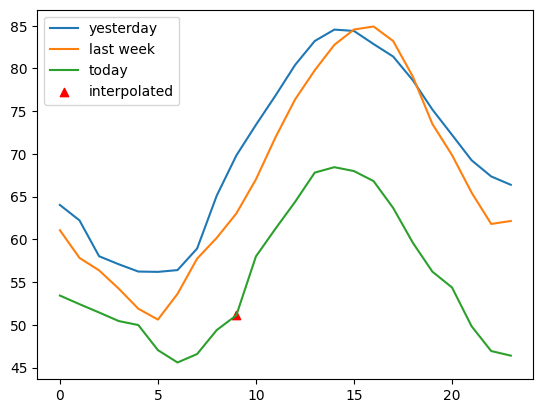

2019-10-03
temperature


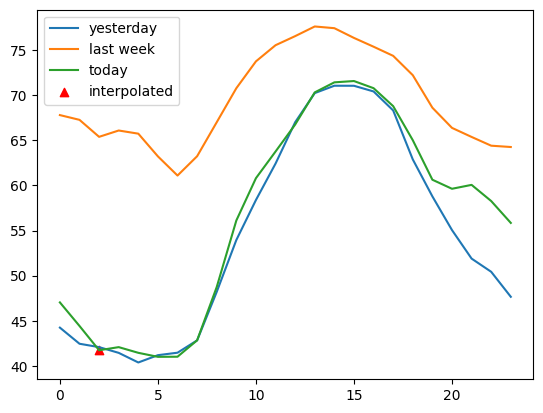

2019-10-05
temperature


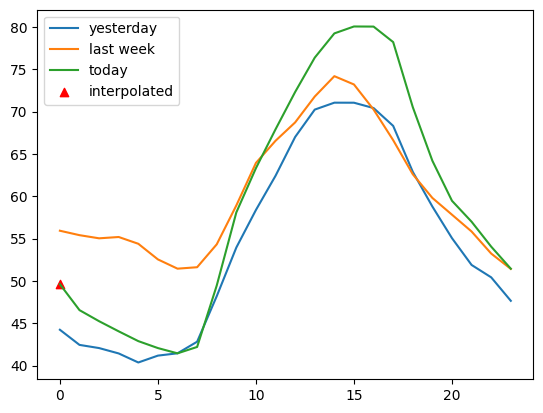

2019-10-08
temperature


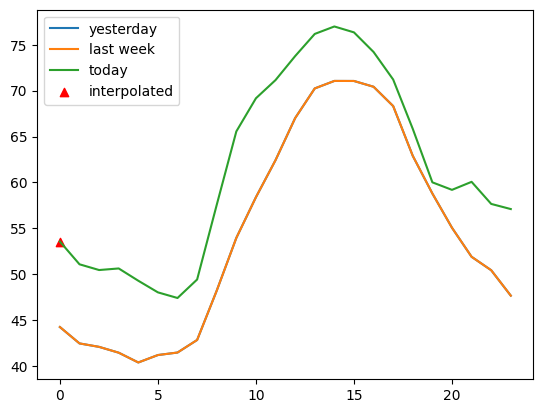

2019-10-13
temperature


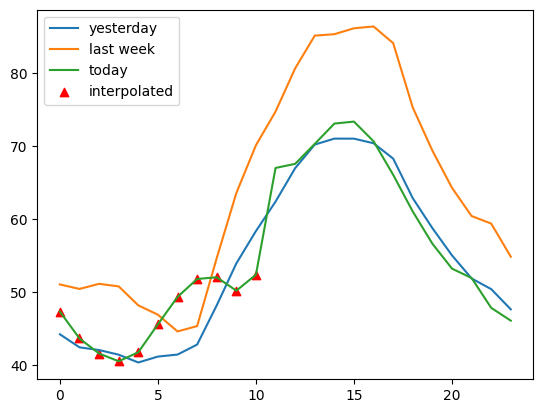

2019-10-15
temperature


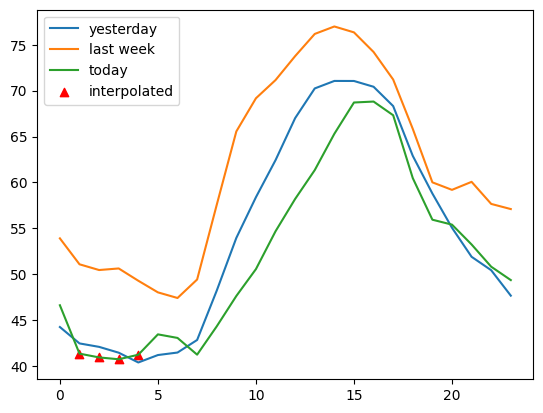

2019-10-16
temperature


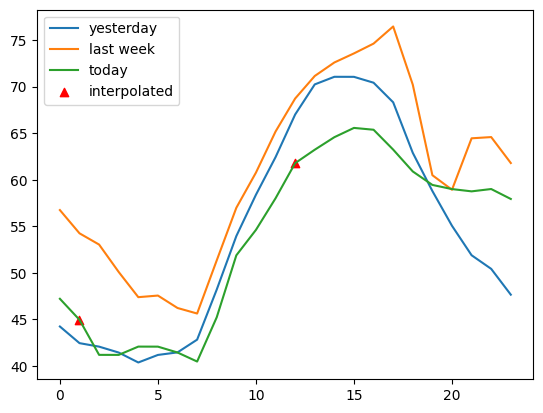

2019-11-03
temperature


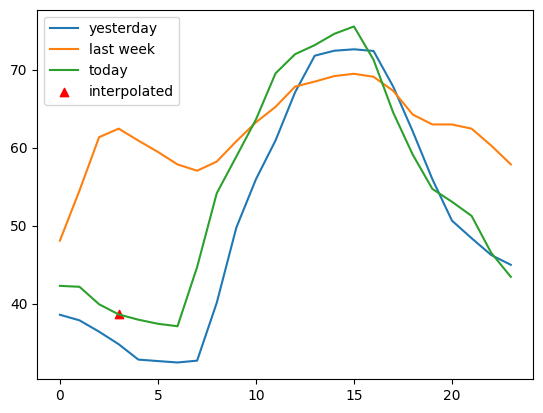

2019-11-08
temperature


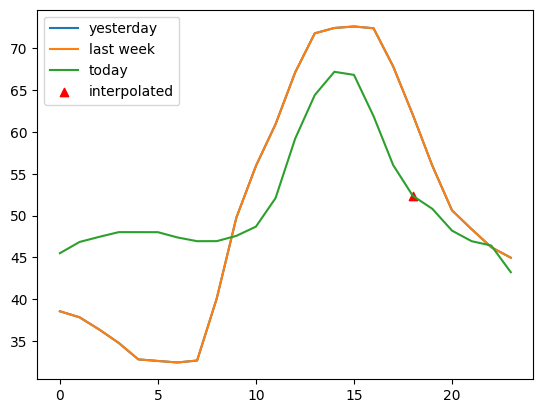

2019-11-11
temperature


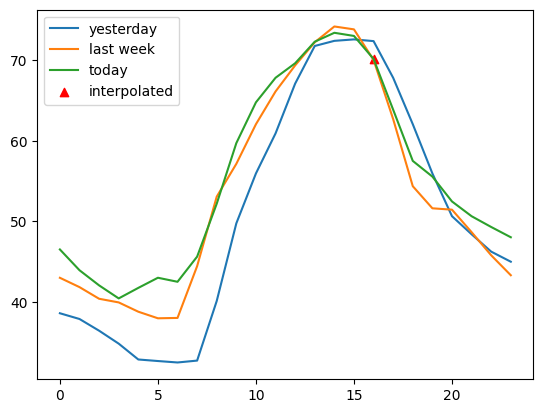

2019-11-13
temperature


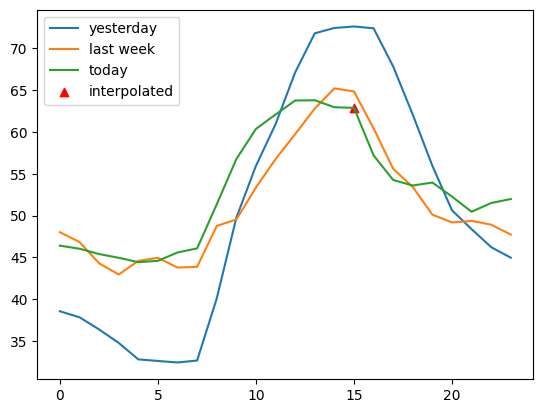

2019-11-18
temperature


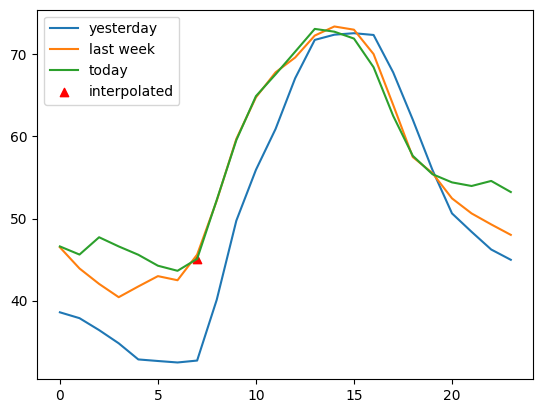

2019-11-19
temperature


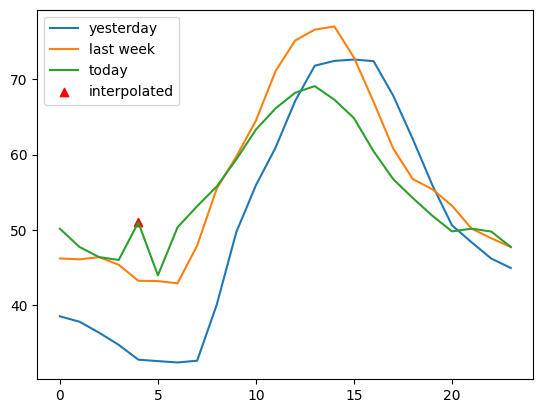

2019-11-21
temperature


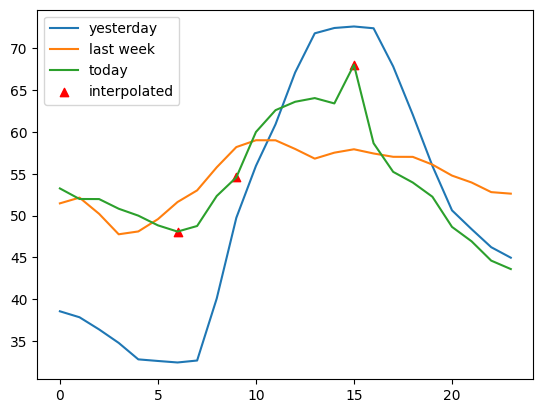

2019-11-22
temperature


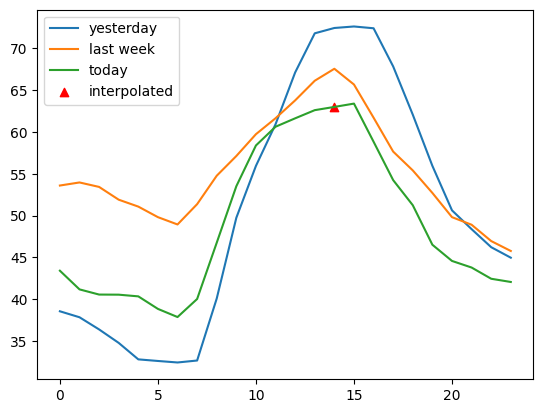

2019-11-23
temperature


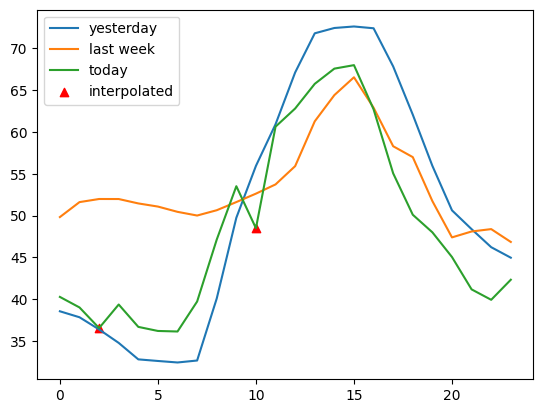

2019-11-24
temperature


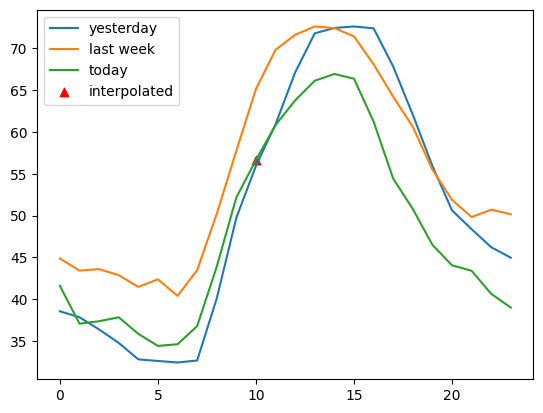

2019-11-25
temperature


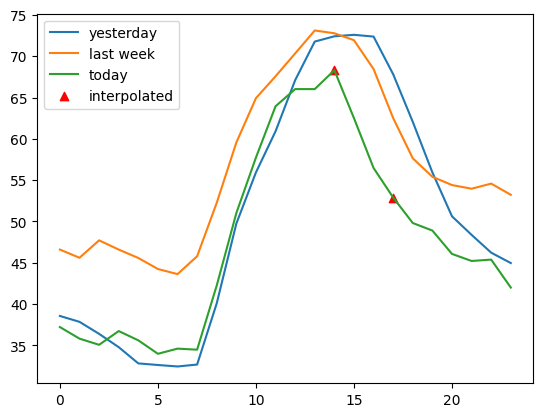

2019-11-26
temperature


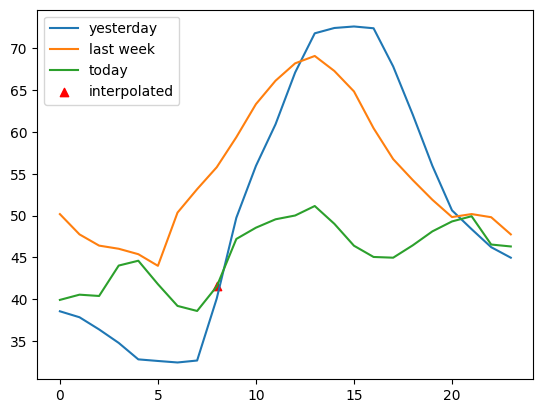

2019-11-29
temperature


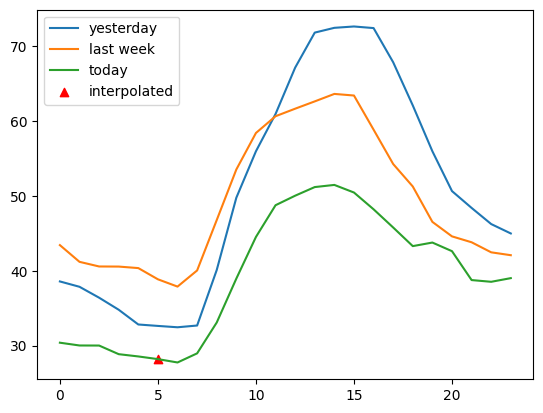

2019-11-30
temperature


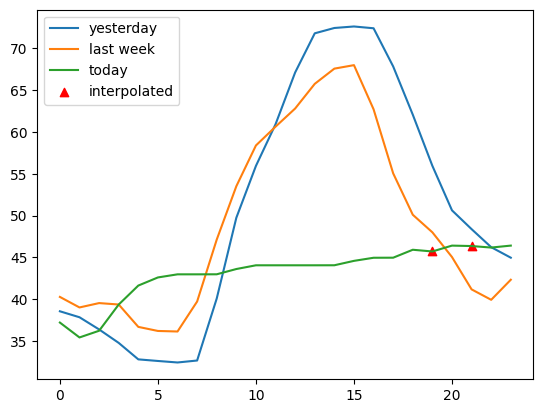

2019-12-10
temperature


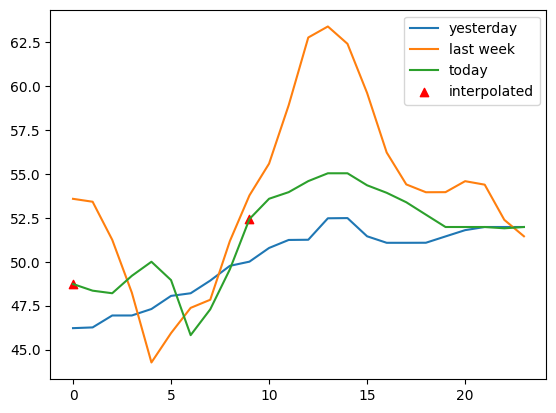

2019-12-11
temperature


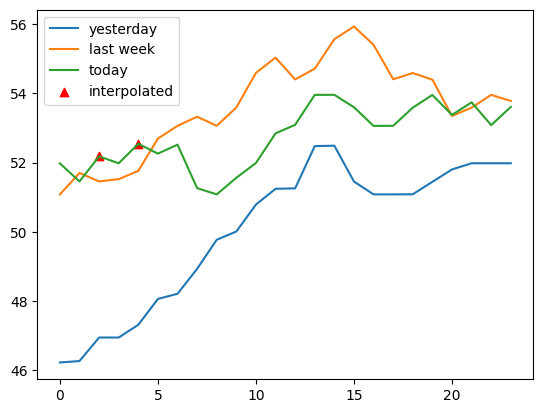

2019-12-13
temperature


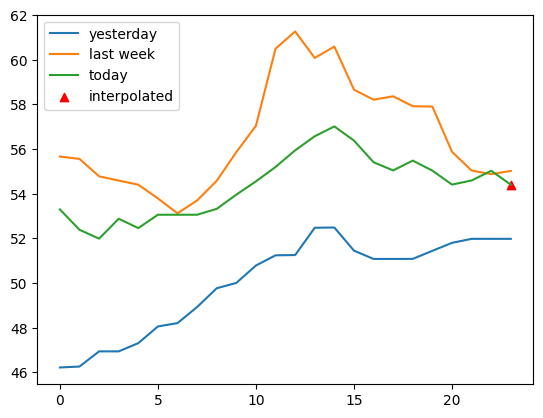

2019-12-14
temperature


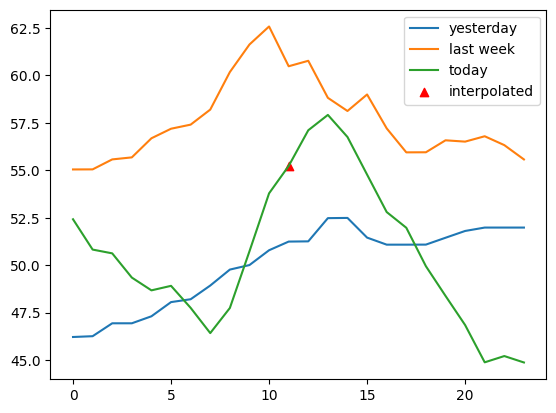

2019-12-16
temperature


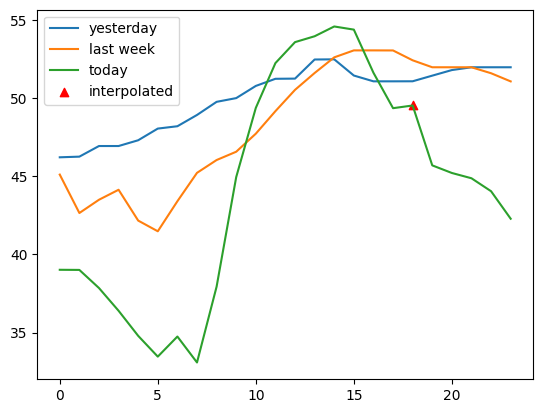

2019-12-17
temperature


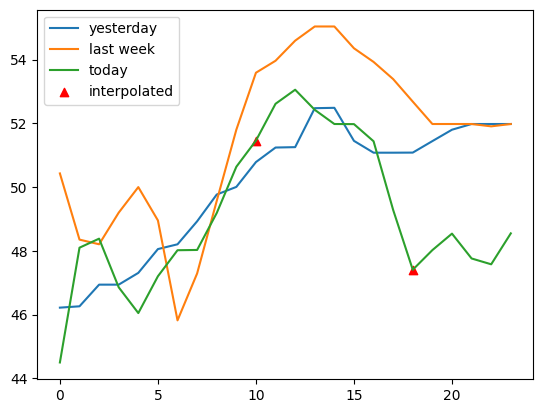

2019-12-23
temperature


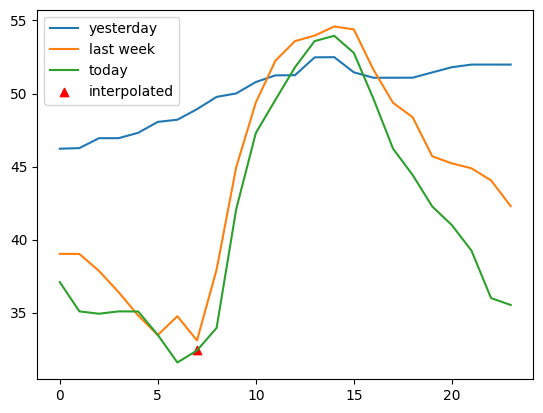

2019-12-24
temperature


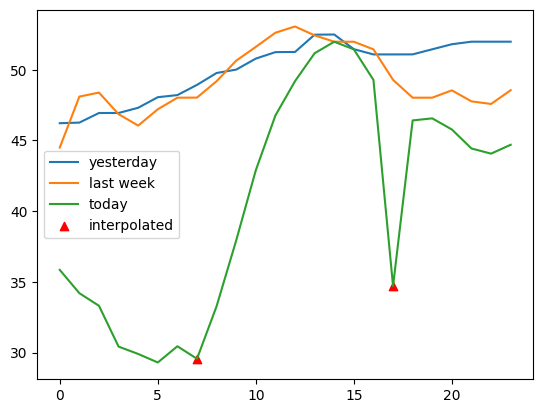

2019-12-25
temperature


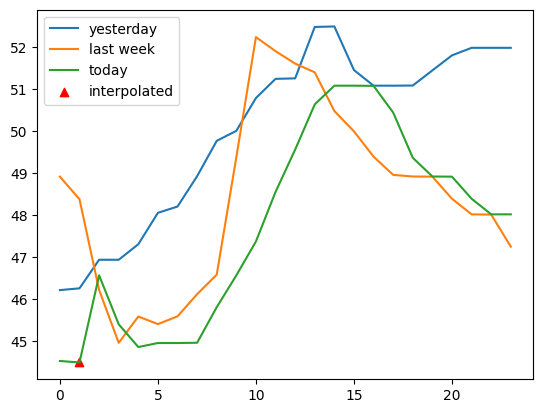

2019-12-29
temperature


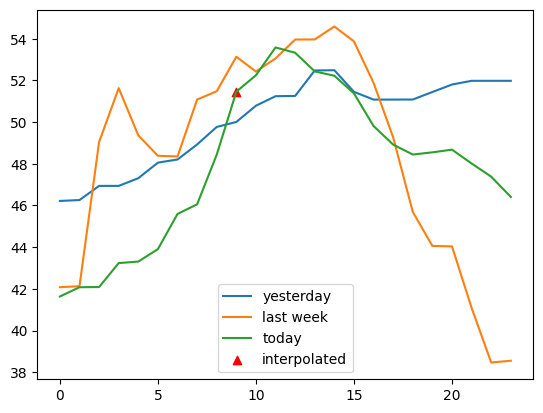

2020-01-03
observed


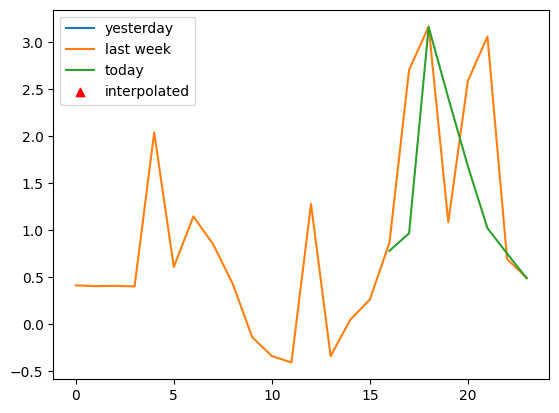

2020-01-05
temperature


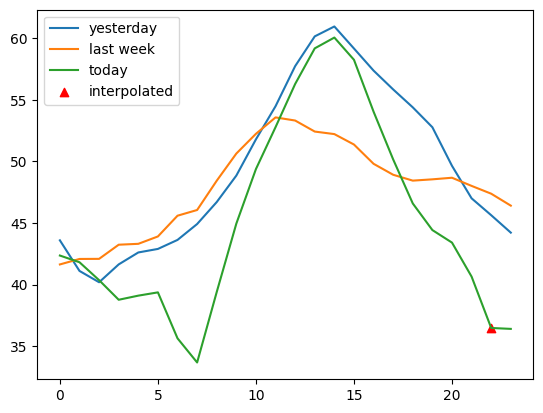

2020-01-07
temperature


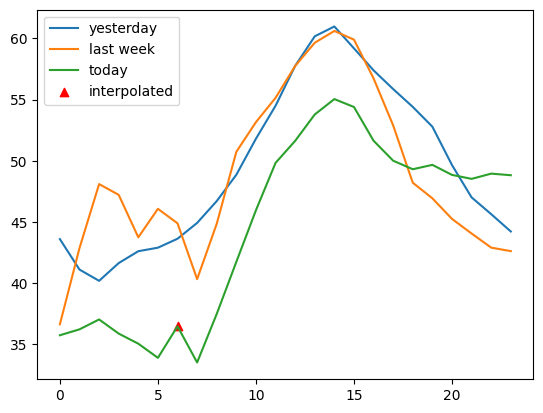

2020-01-09
temperature


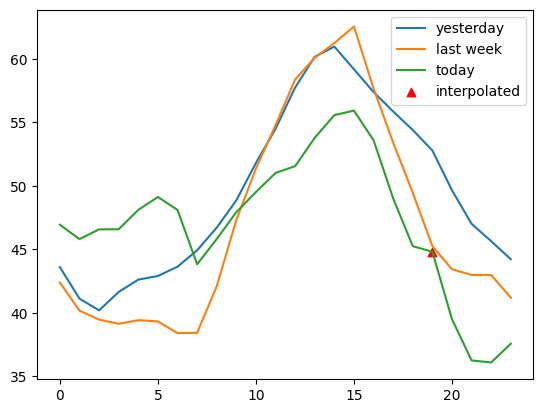

2020-01-11
temperature


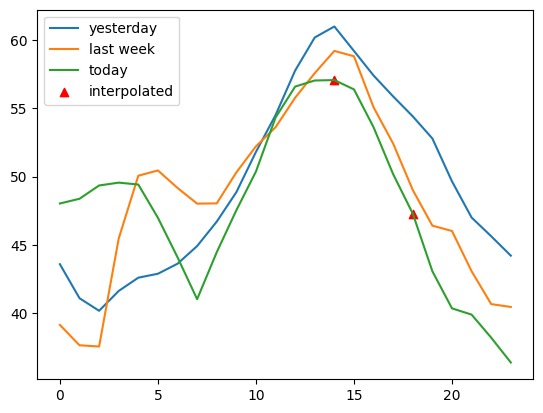

2020-01-13
temperature


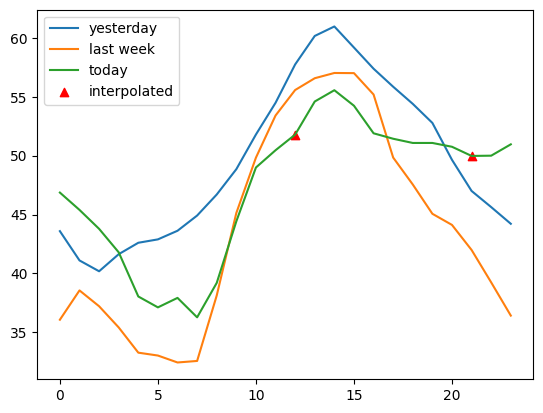

2020-01-16
temperature


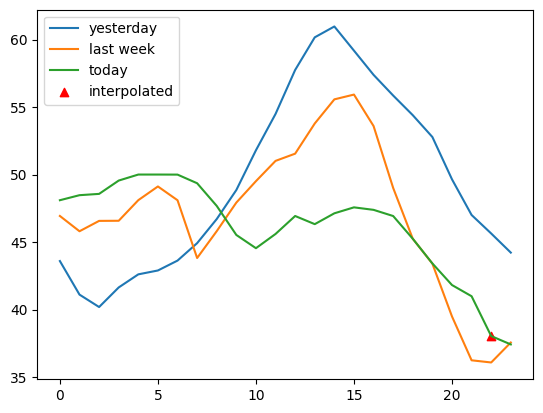

2020-01-19
temperature


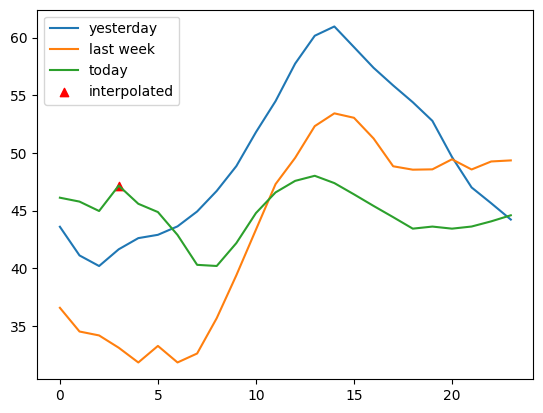

2020-01-20
temperature


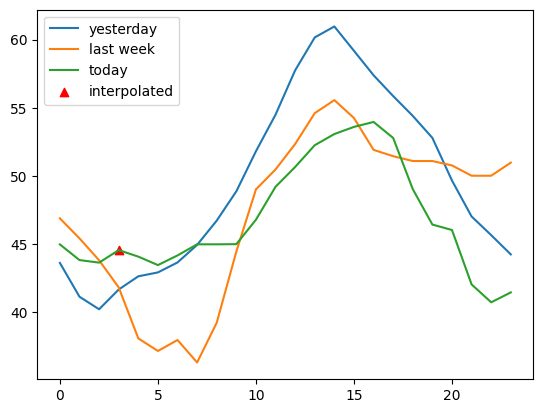

2020-01-22
temperature


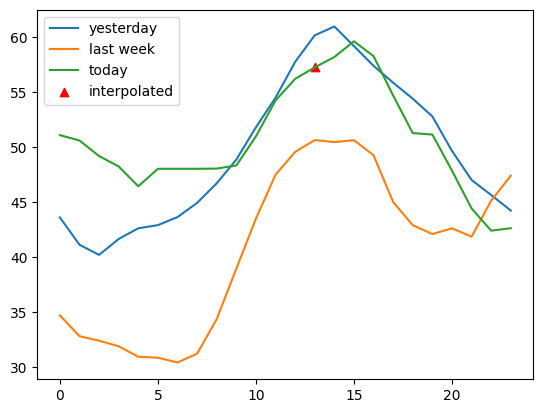

2020-01-27
temperature


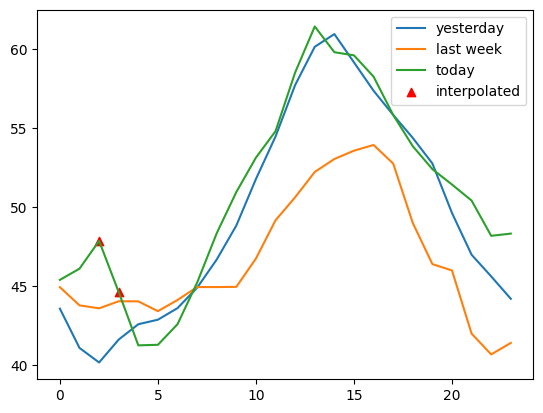

2020-01-28
temperature


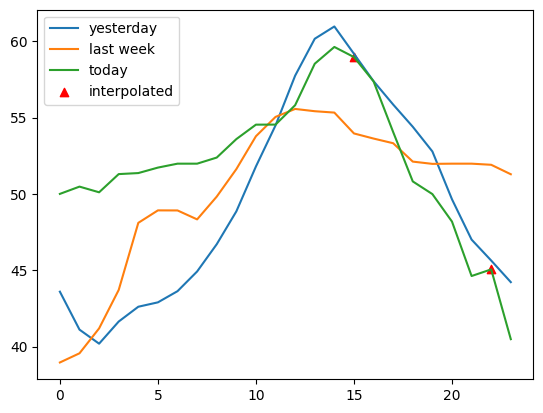

2020-02-02
temperature


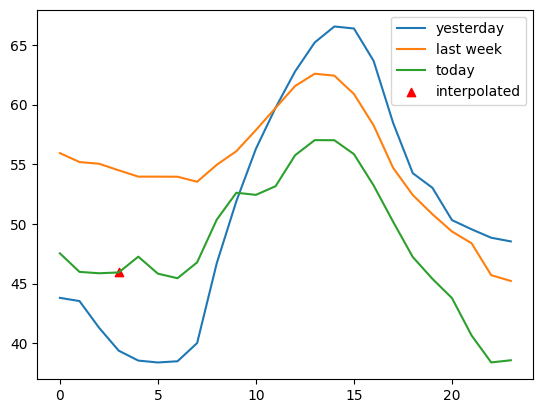

2020-02-06
temperature


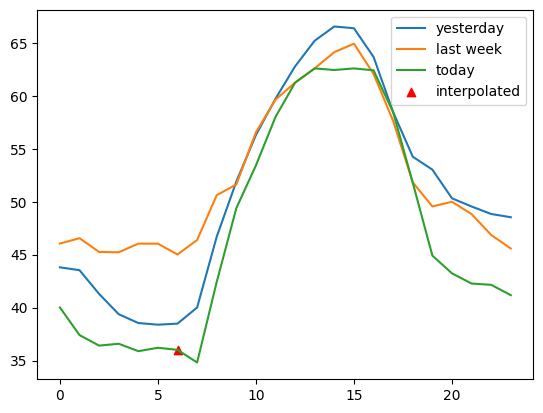

2020-02-07
temperature


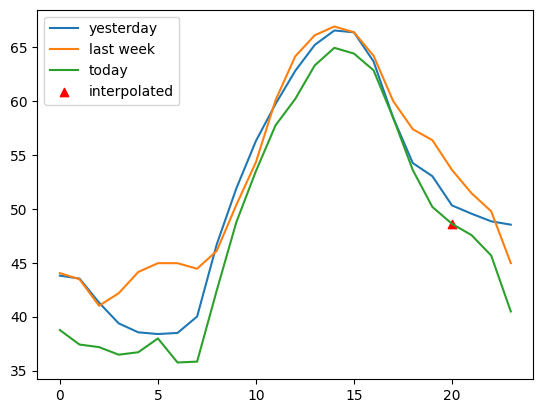

2020-02-10
temperature


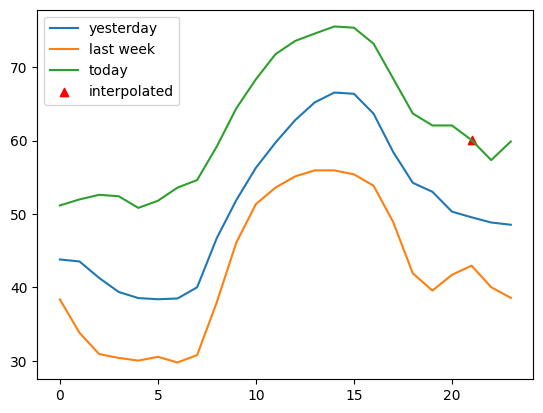

2020-02-10
observed


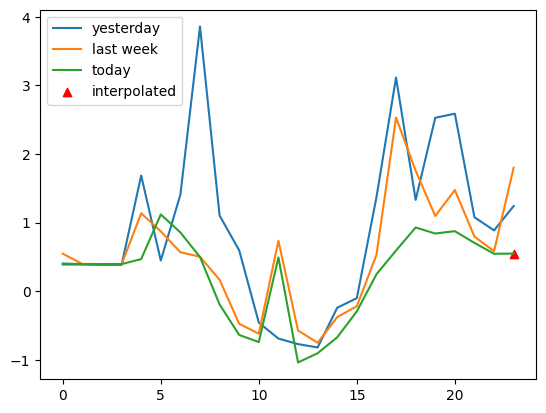

2020-02-11
temperature


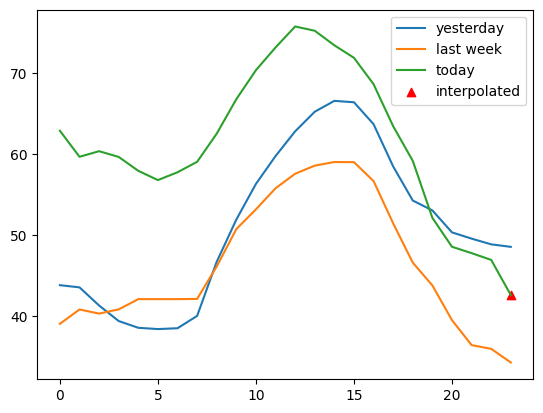

2020-02-12
temperature


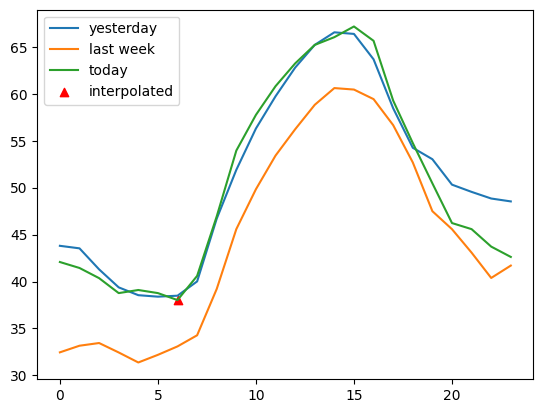

2020-02-13
temperature


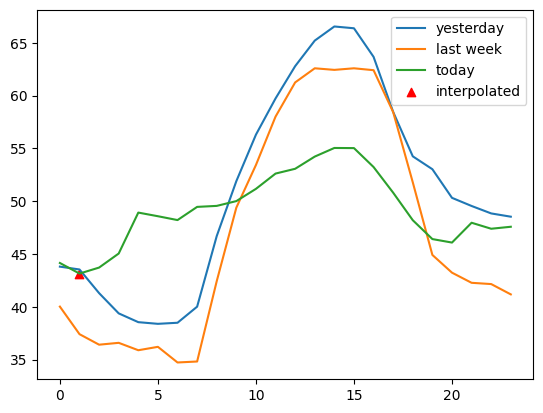

2020-02-16
temperature


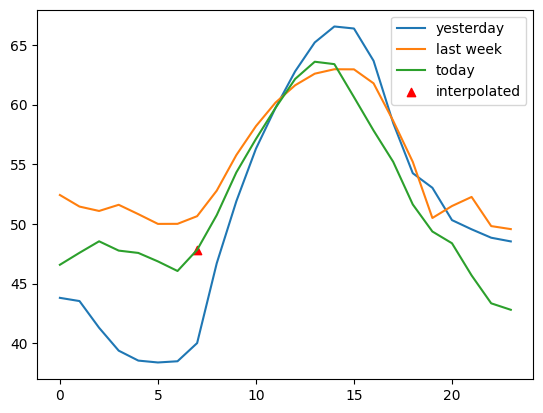

2020-02-19
temperature


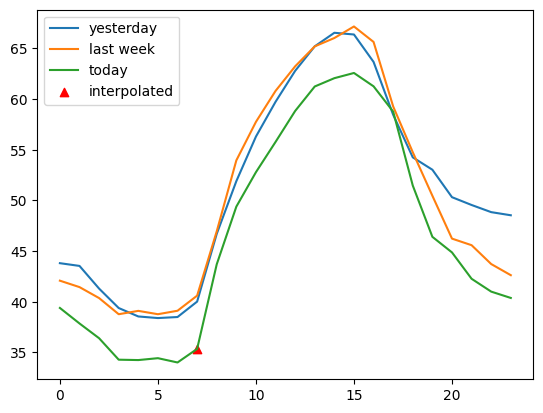

2020-02-23
temperature


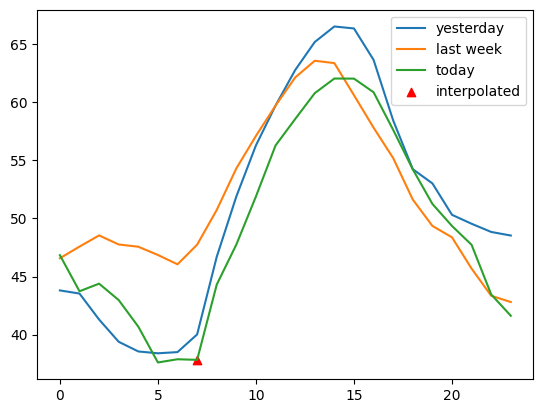

2020-02-25
temperature


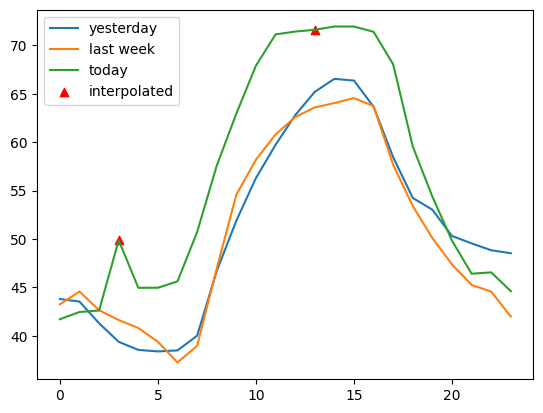

2020-02-27
temperature


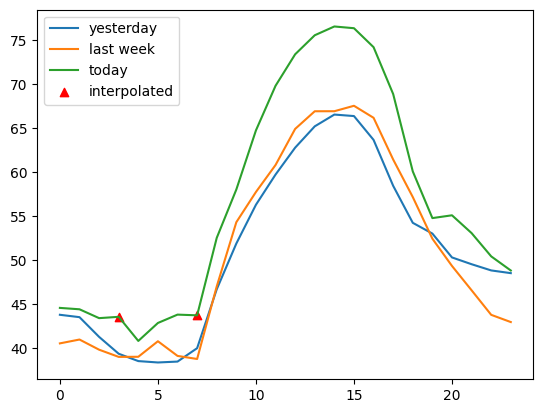

[datetime.date(2020, 1, 1), datetime.date(2020, 1, 2)]


In [93]:
from scipy.interpolate import RBFInterpolator, griddata, LinearNDInterpolator, NearestNDInterpolator, CloughTocher2DInterpolator

"""griddata: need an actual limit for the input such as temp (like a grid) which we don't want to have
   LinearNDInterpolator" if the data is out of bound based on the train data, it gives us nan :( which is crazy that it doesn't even extrapolate
   NearestNDInterpolator: values are descrete and way off sometimes (we have the mean value of couple of classes)
   CloughTocher2DInterpolator: same as LinearNDInterpolator


   Some crazy interpolation is already happening in the MCE temperature (last week and the day before temperatures were exactly the same (reason we we getting singularity in interpolation))
"""
def remove_duplicate_datetime(df):
    if "observed" in df.columns:
        # find duplicate datetime values and remove if nan
        duplicate_dt_mask = df.duplicated(subset="datetime", keep=False)
        observed_nan_mask = df['observed'].isna()
        df = df[~(duplicate_dt_mask & observed_nan_mask)]

        # if duplicated and observed is not nan, keep the largest abs(value)
        df["abs_observed"] = df["observed"].abs()
        df = df.sort_values(by=["datetime", "abs_observed"], ascending=[True, False])
        df = df.drop_duplicates(subset="datetime", keep="first")
        df = df.drop(columns=["abs_observed"])

    else:
        # TODO what if there is no observed column? Could have dup datetime with different temperatures
        df = df.drop_duplicates(subset="datetime", keep="first")

    return df

grouped_meter_baseline = meter_baseline_nans.copy()
grouped_meter_baseline['interpolated'] = False
grouped_meter_baseline = grouped_meter_baseline.groupby('date')


none_regular_dates = []
daily_thr_nans = 0
seeds = [0, 1]
for date, group in grouped_meter_baseline:
    group = remove_duplicate_datetime(group)
    if (
        group['temperature'].isna().sum() > daily_thr_nans
        ) or (
            group['observed'].isna().sum() > daily_thr_nans
        ):

        #remove any duplicate

        interpolation_columns = ['temperature', 'observed']

        #get previous week date and yesterday
        yesterday = date - pd.DateOffset(day=1)
        yesterday_df = meter_baseline.loc[meter_baseline['date']==yesterday.date()]
        yesterday_df = remove_duplicate_datetime(yesterday_df)

        last_week = date - pd.DateOffset(weeks=1)
        last_week_df = meter_baseline.loc[meter_baseline['date']==last_week.date()]
        last_week_df = remove_duplicate_datetime(last_week_df)

        if ((yesterday_df.empty==True) and (last_week_df.empty==True)):
            #make a linear interpolation from what we have
            group[interpolation_columns] = group[interpolation_columns].interpolate()

        else:
            intepolation_helper_days = []
            if yesterday_df.empty==False:
                intepolation_helper_days.append(yesterday_df)
            
            if last_week_df.empty==False:
                intepolation_helper_days.append(last_week_df)

            helper_vectors_nans = []
            helper_vectors_normal = []

            for inter_col in interpolation_columns:
                if group[inter_col].isna().sum()>0:
                    # print(inter_col)
                    for i, interp_df in enumerate(intepolation_helper_days):
                
                        # get index of those without temperature
                        nan_hours = group.loc[group[inter_col].isna()]['hour_of_day'].values
                        interp_df_nans = interp_df.loc[interp_df['hour_of_day'].isin(nan_hours)][inter_col].values

                        #get any other hours that is not in nan_hours
                        normal_hours = group.loc[~group[inter_col].isna()]['hour_of_day'].values
                        interp_df_normal = interp_df.loc[interp_df['hour_of_day'].isin(normal_hours)][inter_col].values

                        #singularity prevention
                        np.random.seed = seeds[i]
                        noise = np.random.normal(0, 1, len(interp_df_normal))
                        interp_df_normal += noise

                        helper_vectors_normal.append(interp_df_normal)
                        helper_vectors_nans.append(interp_df_nans)
                        
                    if len(helper_vectors_normal) == 1:
                        temp_vector_normal = helper_vectors_normal[0].reshape(-1,1)
                        temp_vector_nans = helper_vectors_nans[0].reshape(-1,1)
                    else:
                        temp_vector_normal = list(zip(helper_vectors_normal[0], helper_vectors_normal[1]))
                        temp_vector_nans = list(zip(helper_vectors_nans[0], helper_vectors_nans[1]))

                        
                    # target_vector = group.loc[~group[inter_col].isna()][inter_col].values
                    target_vector = group.loc[group['hour_of_day'].isin(normal_hours)][inter_col].values
                    if len(target_vector)==0:
                        none_regular_dates.append(date)
                        pass
                    else:
                        interp = RBFInterpolator(temp_vector_normal, target_vector)
                        preds = interp(temp_vector_nans)
                        group.loc[group['hour_of_day'].isin(nan_hours), inter_col] = preds

                        x = group['hour_of_day'].values
                        for j, interp_df in enumerate(intepolation_helper_days):
                            lbl = 'yesterday'
                            if j==1:
                                lbl = 'last week'
                            plt.plot(x,interp_df[inter_col], label = lbl)
                        
                        plt.plot(x,group[inter_col], label = 'today')
                        #plot temp values for interpolated hours as red
                        xp = group.loc[group['hour_of_day'].isin(nan_hours)]['hour_of_day'].values
                        plt.scatter(xp, group.loc[group['hour_of_day'].isin(nan_hours), inter_col], marker='^', color='red',label='interpolated')
                        print(date)
                        print(inter_col)
                        plt.legend()
                        plt.show()

print(none_regular_dates)

In [141]:
meter_baseline_nans
print(meter_baseline_nans['temperature'].isna().sum())
print(meter_baseline_nans['observed'].isna().sum())

0
66


In [140]:
meter_baseline_nans

start_local        date    period  \
dpsm_id                                                                    
None-1572616610_1-1572616610_1 2019-03-02 00:00:00  2019-03-02  baseline   
None-1572616610_1-1572616610_1 2019-03-02 01:00:00  2019-03-02  baseline   
None-1572616610_1-1572616610_1 2019-03-02 02:00:00  2019-03-02  baseline   
None-1572616610_1-1572616610_1 2019-03-02 03:00:00  2019-03-02  baseline   
None-1572616610_1-1572616610_1 2019-03-02 04:00:00  2019-03-02  baseline   
...                                            ...         ...       ...   
None-1572616610_1-1572616610_1 2020-02-29 19:00:00  2020-02-29  baseline   
None-1572616610_1-1572616610_1 2020-02-29 20:00:00  2020-02-29  baseline   
None-1572616610_1-1572616610_1 2020-02-29 21:00:00  2020-02-29  baseline   
None-1572616610_1-1572616610_1 2020-02-29 22:00:00  2020-02-29  baseline   
None-1572616610_1-1572616610_1 2020-02-29 23:00:00  2020-02-29  baseline   

                                year    season  month  day_of_year  \
dpsm_id                                                              
None-1572616610_1-1572616610_1  2019  shoulder      3           60   
None-1572616610_1-1572616610_1  2019  shoulder      3           60   
None-1572616610_1-1572616610_1  2019  shoulder      3           60   
None-1572616610_1-1572616610_1  2019  shoulder      3           60   
None-1572616610_1-1572616610_1  2019  shoulder      3           60   
...                              ...       ...    ...          ...   
None-1572616610_1-1572616610_1  2020    winter      2           59   
None-1572616610_1-1572616610_1  2020    winter      2           59   
None-1572616610_1-1572616610_1  2020    winter      2           59   
None-1572616610_1-1572616610_1  2020    winter      2           59   
None-1572616610_1-1572616610_1  2020    winter      2           59   

                                day_of_week  is_weekend  hour_of_year  \
dpsm_id                                                                 
None-1572616610_1-1572616610_1            6        True          1440   
None-1572616610_1-1572616610_1            6        True          1441   
None-1572616610_1-1572616610_1            6        True          1442   
None-1572616610_1-1572616610_1            6        True          1443   
None-1572616610_1-1572616610_1            6        True          1444   
...                                     ...         ...           ...   
None-1572616610_1-1572616610_1            6        True          1435   
None-1572616610_1-1572616610_1            6        True          1436   
None-1572616610_1-1572616610_1            6        True          1437   
None-1572616610_1-1572616610_1            6        True          1438   
None-1572616610_1-1572616610_1            6        True          1439   

                                hour_of_week  hour_of_day  temperature  \
dpsm_id                                                                  
None-1572616610_1-1572616610_1             6            0     52.76180   
None-1572616610_1-1572616610_1             7            1     51.43775   
None-1572616610_1-1572616610_1             8            2     51.08000   
None-1572616610_1-1572616610_1             9            3     51.08000   
None-1572616610_1-1572616610_1            10            4     51.07078   
...                                      ...          ...          ...   
None-1572616610_1-1572616610_1            25           19     53.06000   
None-1572616610_1-1572616610_1            26           20     53.04845   
None-1572616610_1-1572616610_1            27           21     51.86075   
None-1572616610_1-1572616610_1            28           22     50.42930   
None-1572616610_1-1572616610_1            29           23     49.99370   

                                observed     model  solar_supp  \
dpsm_id                                                          
None-1572616610_1-1572616610_1    0.6292  0.753882           0   
None-1572616610_1-1572616610

In [98]:
temp_vector_normal

[]

In [87]:
nan_hours

array([1], dtype=int32)

In [42]:
len(target_vector)

25

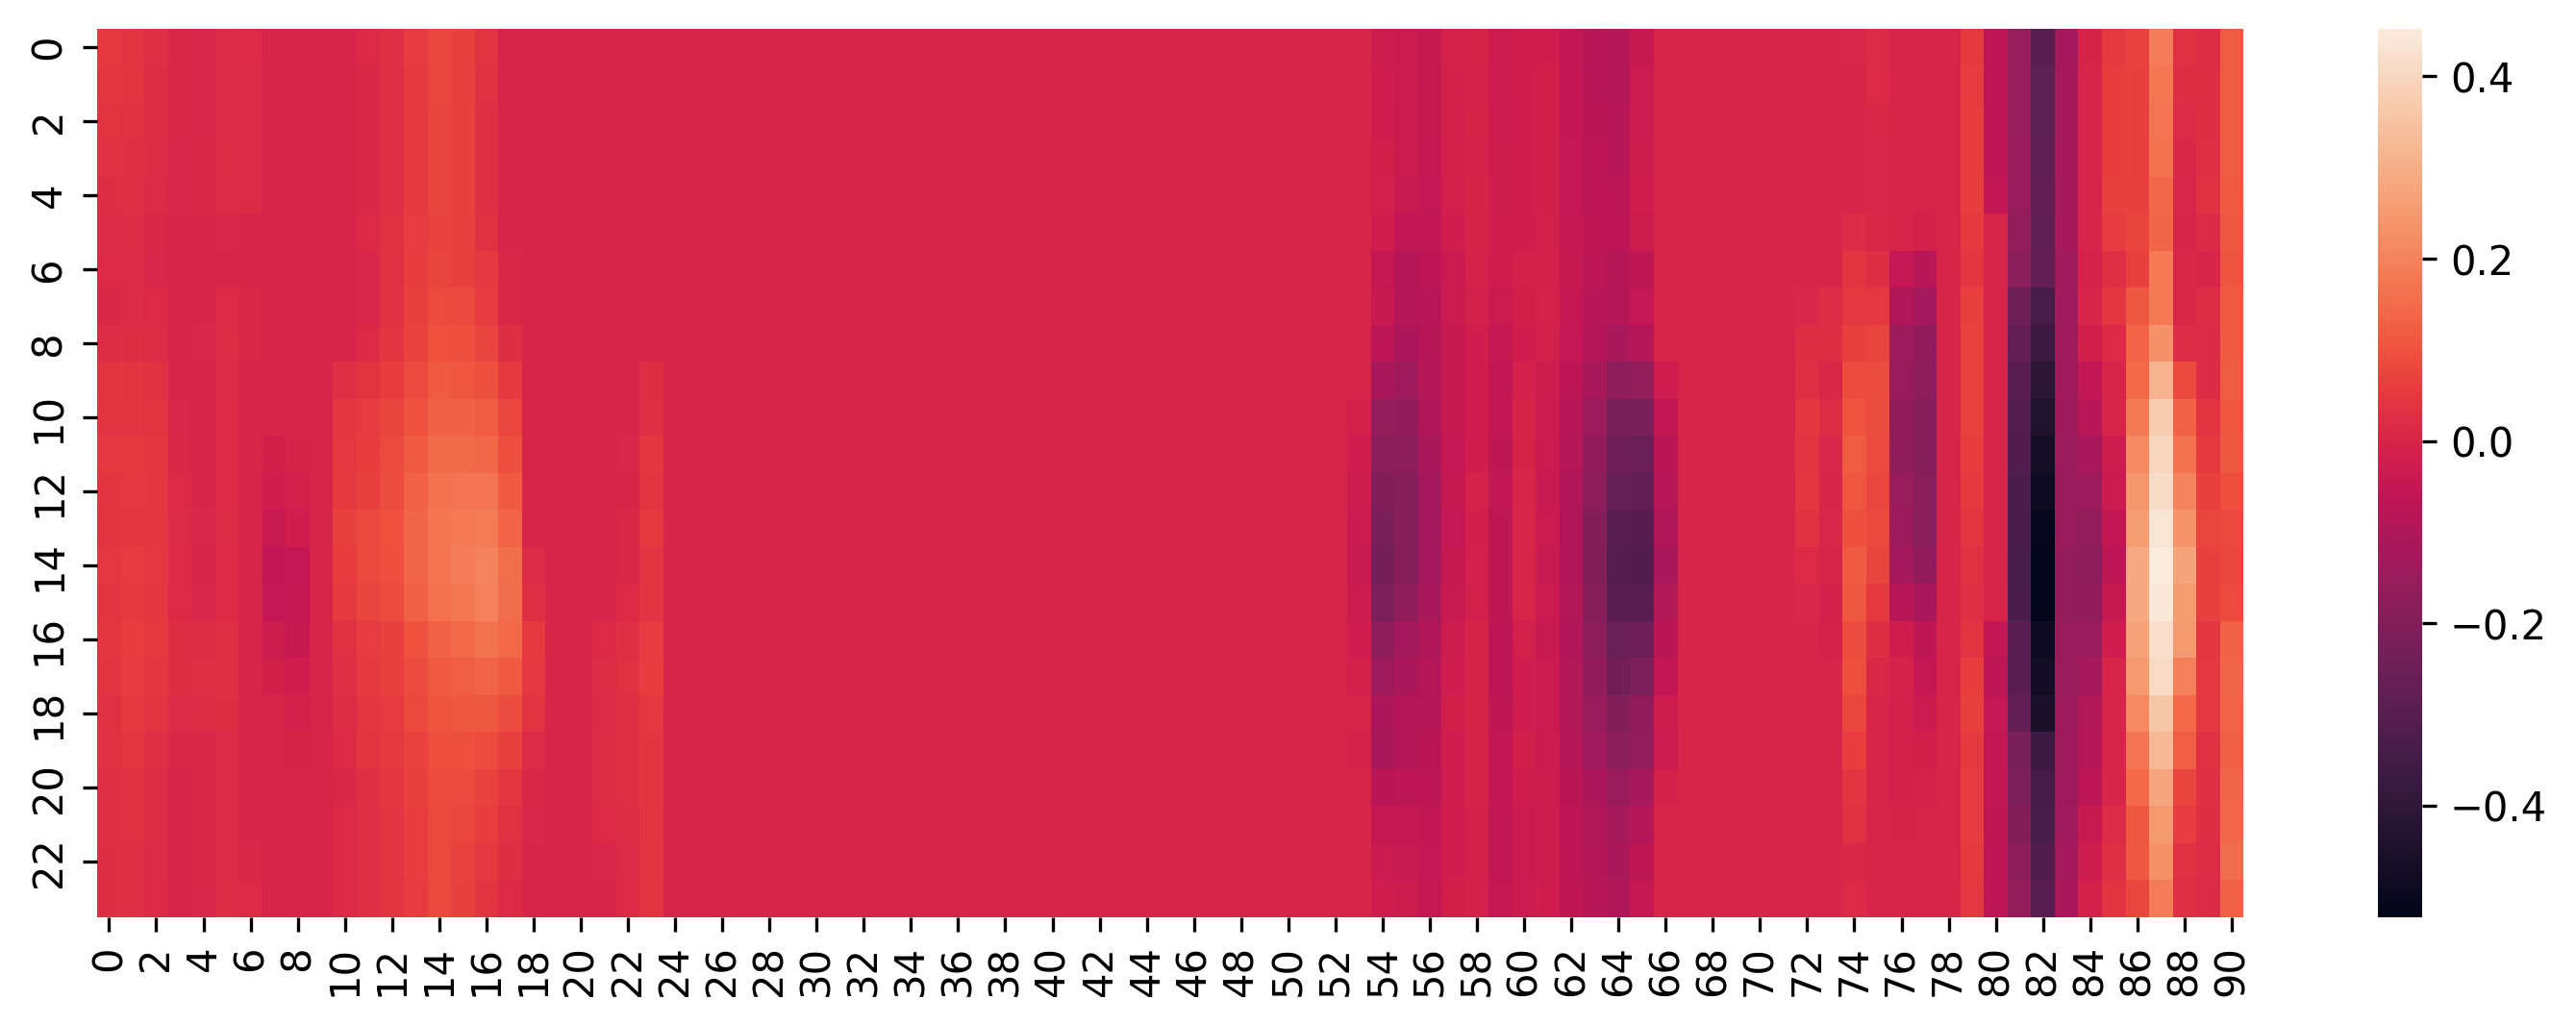

In [32]:
# heatmap fro the model._model.coef_
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model_coef = model._model.coef_
# # assuming model_coef is a 1D array, we reshape it to 2D for the heatmap
# model_coef_2d = model_coef.reshape(-1, 1)

#fig size
plt.rcParams['figure.figsize'] = [12, 4]
sns.heatmap(model_coef)
plt.show()
# get the model coefficients

In [33]:
pred_baseline

temperature    observed       model  solar_supp  ghi  \
datetime                                                                    
2019-03-02 00:00:00     52.76180  104.800000   96.111425         0.0  0.0   
2019-03-02 01:00:00     51.43775  104.800000   98.272022         0.0  0.0   
2019-03-02 02:00:00     51.08000  104.800000   98.175642         0.0  0.0   
2019-03-02 03:00:00     51.08000  104.800000   96.926643         0.0  0.0   
2019-03-02 04:00:00     51.07078  104.800000   94.924831         0.0  0.0   
...                          ...         ...         ...         ...  ...   
2020-02-29 19:00:00     53.06000  153.600000  140.780725         0.0  0.0   
2020-02-29 20:00:00     53.04845  148.800000  136.584485         0.0  0.0   
2020-02-29 21:00:00     51.86075  140.000000  134.143621         0.0  0.0   
2020-02-29 22:00:00     50.42930  138.400000  135.155206         0.0  0.0   
2020-02-29 23:00:00     49.99370  131.999997  130.465031         0.0  0.0   

                     clearsky_ghi  interpolated   predicted  
datetime                                                     
2019-03-02 00:00:00           0.0         False  142.817930  
2019-03-02 01:00:00           0.0         False  142.483776  
2019-03-02 02:00:00           0.0         False  142.433260  
2019-03-02 03:00:00           0.0         False  141.970944  
2019-03-02 04:00:00           0.0         False  141.350226  
...                           ...           ...         ...  
2020-02-29 19:00:00           NaN          True         NaN  
2020-02-29 20:00:00           NaN          True         NaN  
2020-02-29 21:00:00           NaN          True         NaN  
2020-02-29 22:00:00           NaN          True         NaN  
2020-02-29 23:00:00           NaN          True         NaN  

[8760 rows x 8 columns]

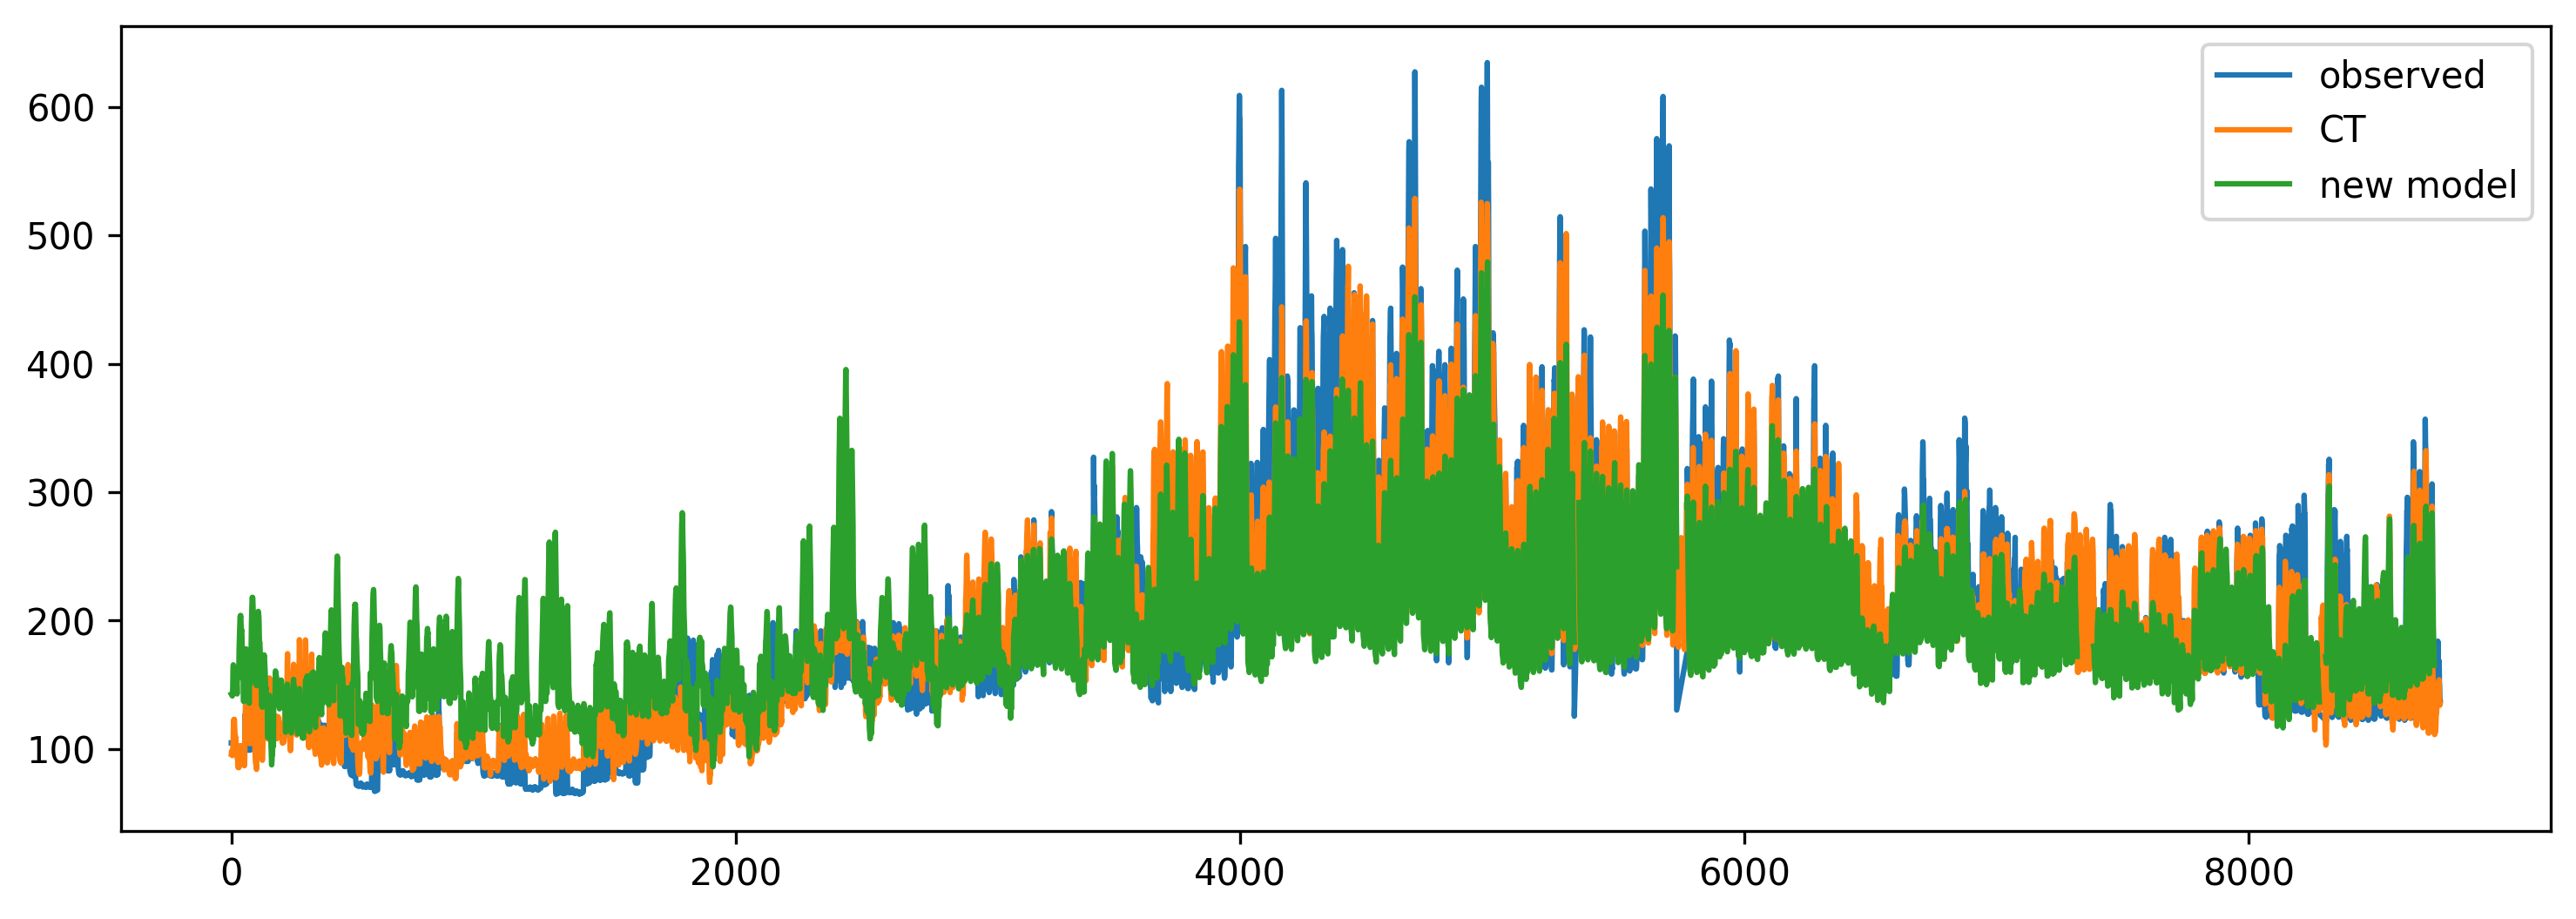

In [34]:
s = 0
w = -1
e = s + w
plt.plot(pred_baseline['observed'].iloc[s:e].values, label='observed')
plt.plot(pred_baseline['model'].iloc[s:e].values, label='CT')
plt.plot(pred_baseline['predicted'].iloc[s:e].values, label='new model')
# plt.plot(-pred_baseline['ghi'].iloc[s:e].values*3, label='ghi')
plt.legend()
plt.show()

In [35]:
meter_reporting = meter.loc[meter['period'] == 'reporting'].copy()
data_reporting = HourlyData(meter_reporting, **kwargs)
reporting_pred = model.predict(data_reporting)
reporting_pred

ValueError: Input X contains NaN.
ElasticNet does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

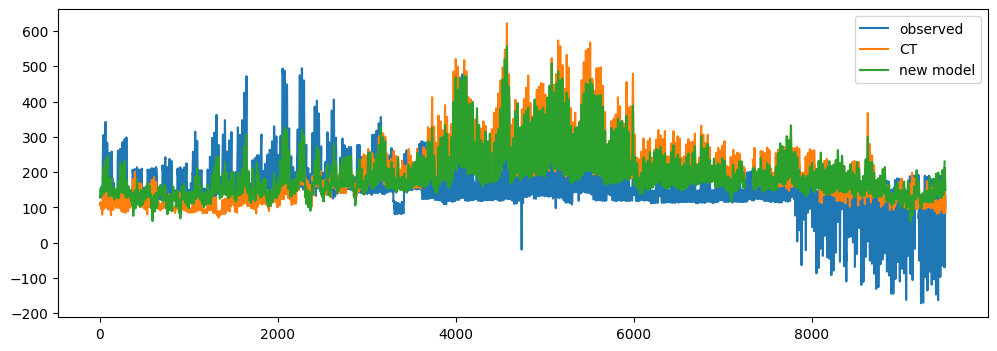

In [ ]:
s = 0
w = -1
e = s + w
plt.plot(reporting_pred['observed'].iloc[s:e].values, label='observed')
plt.plot(reporting_pred['model'].iloc[s:e].values, label='CT')
plt.plot(reporting_pred['predicted'].iloc[s:e].values, label='new model')
# plt.plot(-pred_baseline['ghi'].iloc[s:e].values*3, label='ghi')
plt.legend()
plt.show()

In [ ]:
# pred['temperature'].quantile(0.95)
# find days with temperature above 95th percentile
hot_hours = reporting_pred[reporting_pred['temperature'] > reporting_pred['temperature'].quantile(0.995)]
unique_days = np.unique(hot_hours.index.date)
print(unique_days.shape)

reporting_pred['date'] = reporting_pred.index.date
 # get days that are in unique_days
hot_days = reporting_pred[reporting_pred['date'].isin(unique_days)]
hot_days

(12,)


temperature    observed       model  solar_supp  ghi  \
datetime                                                                    
2020-05-26 00:00:00     71.54255  168.000000  133.048856         1.0  0.0   
2020-05-26 01:00:00     68.77550  156.800000  132.049642         1.0  0.0   
2020-05-26 02:00:00     66.79550  160.800000  130.941328         1.0  0.0   
2020-05-26 03:00:00     64.82075  168.000000  129.424340         1.0  0.0   
2020-05-26 04:00:00     63.38405  161.600000  125.151462         1.0  0.0   
...                          ...         ...         ...         ...  ...   
2020-09-07 19:00:00     98.17325  258.399999  427.049020         1.0  0.0   
2020-09-07 20:00:00     94.57100  167.200000  383.211490         1.0  0.0   
2020-09-07 21:00:00     90.60995  195.200000  334.064123         1.0  0.0   
2020-09-07 22:00:00     86.55410  194.400000  305.867008         1.0  0.0   
2020-09-07 23:00:00     83.70395  133.599999  285.455838         1.0  0.0   

                     clearsky_ghi  interpolated   predicted        date  
datetime                                                                 
2020-05-26 00:00:00           0.0         False  177.086395  2020-05-26  
2020-05-26 01:00:00           0.0         False  174.072296  2020-05-26  
2020-05-26 02:00:00           0.0         False  172.300649  2020-05-26  
2020-05-26 03:00:00           0.0         False  170.332085  2020-05-26  
2020-05-26 04:00:00           0.0         False  168.757252  2020-05-26  
...                           ...           ...         ...         ...  
2020-09-07 19:00:00           0.0         False  365.373075  2020-09-07  
2020-09-07 20:00:00           0.0         False  330.567824  2020-09-07  
2020-09-07 21:00:00           0.0         False  310.585681  2020-09-07  
2020-09-07 22:00:00           0.0         False  296.469835  2020-09-07  
2020-09-07 23:00:00           0.0         False  276.836853  2020-09-07  

[288 rows x 9 columns]

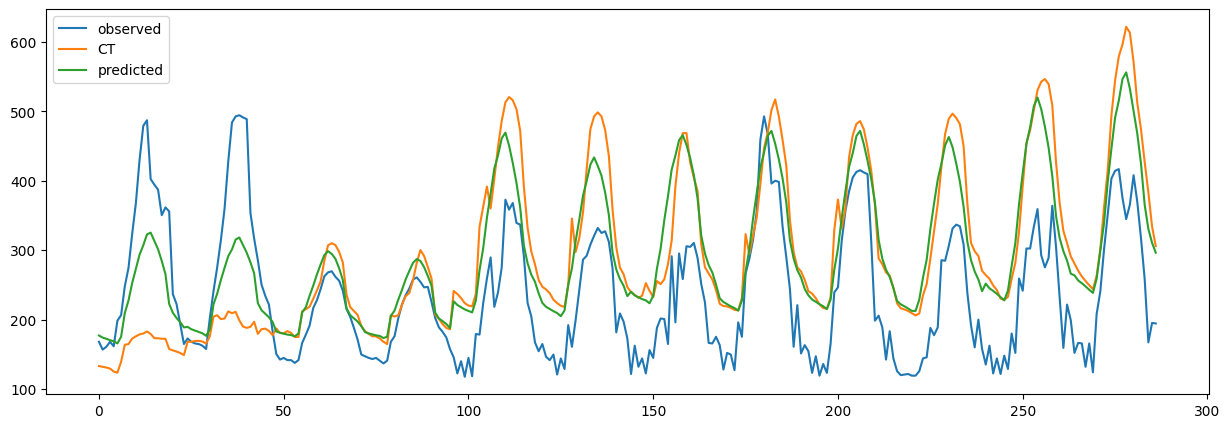

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
s = 24*0
w = -1
e = s + w
plt.plot(hot_days['observed'].iloc[s:e].values, label='observed')
plt.plot(hot_days['model'].iloc[s:e].values, label='CT')
plt.plot(hot_days['predicted'].iloc[s:e].values, label='predicted')
plt.legend()

# plt.plot(-hot_days['ghi'].iloc[s:e].values*7, label='ghi')

plt.show()

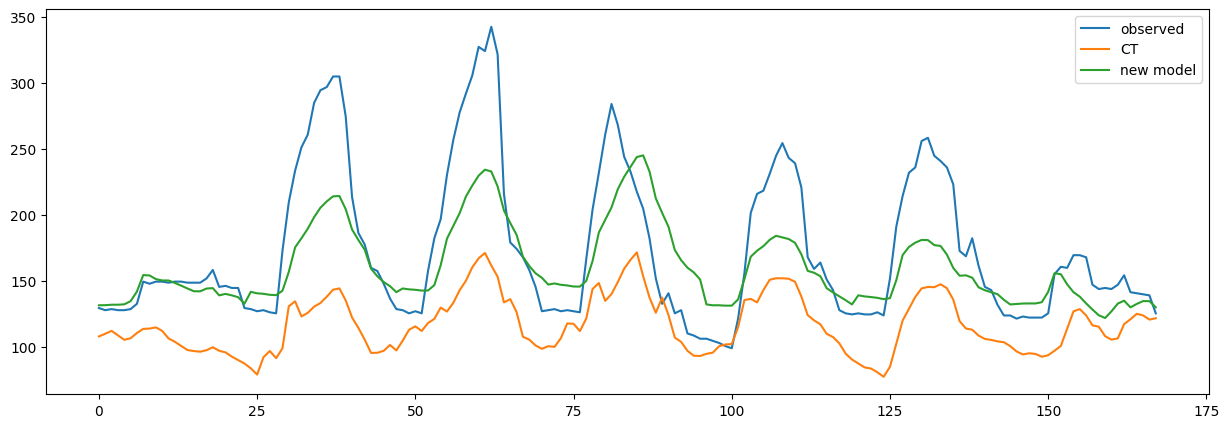

In [ ]:
s = 24*0
w = 24*7
e = s + w
plt.plot(reporting_pred['observed'].iloc[s:e].values, label='observed')
plt.plot(reporting_pred['model'].iloc[s:e].values, label='CT')
plt.plot(reporting_pred['predicted'].iloc[s:e].values, label='new model')
# plt.plot(-pred_baseline['ghi'].iloc[s:e].values*3, label='ghi')
plt.legend()
plt.show()

In [ ]:
def PNRMSE(y_true, y_pred, iqr):
    return np.sqrt(np.mean((y_true - y_pred)**2))/iqr

def CVRMSE(y_true, y_pred, mn):
    return np.sqrt(np.mean((y_true - y_pred)**2))/mn

def MBE(y_true, y_pred):
    return np.mean(y_true - y_pred)



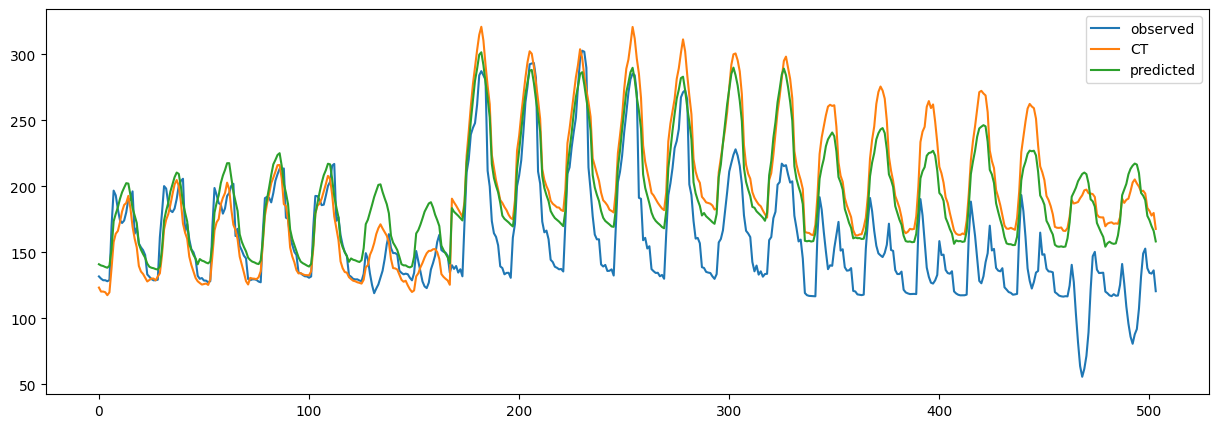

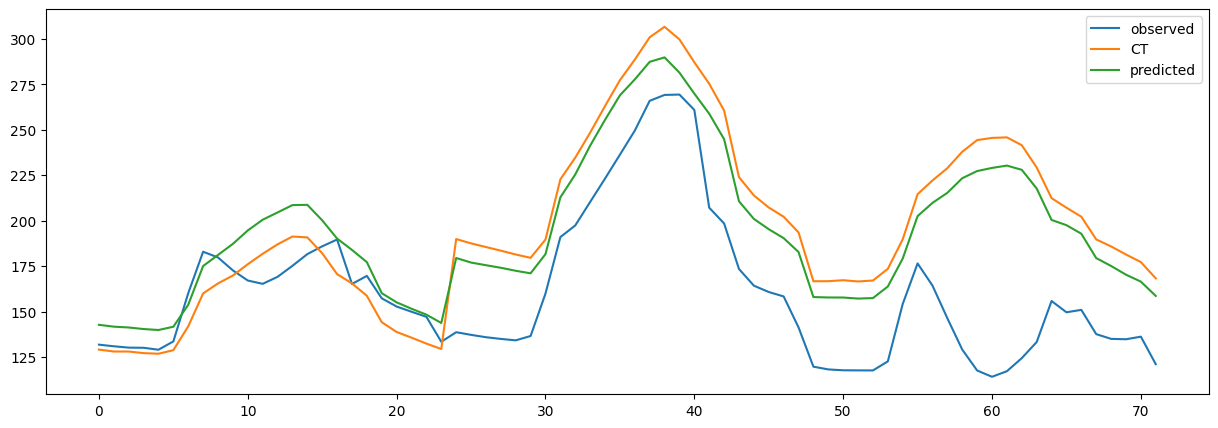

In [ ]:
# plot the season/hour_of_week plots
# get the season and hour_of_week
seasons = {'winter': [11, 12, 1, 2], 'shoulder': [3, 4, 5, 10], 'summer': [6, 7, 8, 9]}
reporting_pred['season'] = reporting_pred.index.month
reporting_pred['season'] = reporting_pred['season'].apply(lambda x: 'winter' if x in seasons['winter'] else ('shoulder' if x in seasons['shoulder'] else 'summer'))
reporting_pred['season'] = reporting_pred['season'].astype('category')

reporting_pred['hour_of_week'] = reporting_pred.index.dayofweek*24 + reporting_pred.index.hour
reporting_pred['hour_of_week'] = reporting_pred['hour_of_week'].astype('category')

reporting_pred['hour'] = reporting_pred.index.hour
reporting_pred['hour'] = reporting_pred['hour'].astype('category')


# get the season/hour_of_week plots
plt.rcParams['figure.figsize'] = [15, 5]

plt.plot(reporting_pred.groupby(['season', 'hour_of_week'])['observed'].mean().values, label='observed')
plt.plot(reporting_pred.groupby(['season', 'hour_of_week'])['model'].mean().values, label='CT')
plt.plot(reporting_pred.groupby(['season', 'hour_of_week'])['predicted'].mean().values, label='predicted')
plt.legend()
plt.show()


plt.plot(reporting_pred.groupby(['season', 'hour'])['observed'].mean().values, label='observed')
plt.plot(reporting_pred.groupby(['season', 'hour'])['model'].mean().values, label='CT')
plt.plot(reporting_pred.groupby(['season', 'hour'])['predicted'].mean().values, label='predicted')
plt.legend()
plt.show()

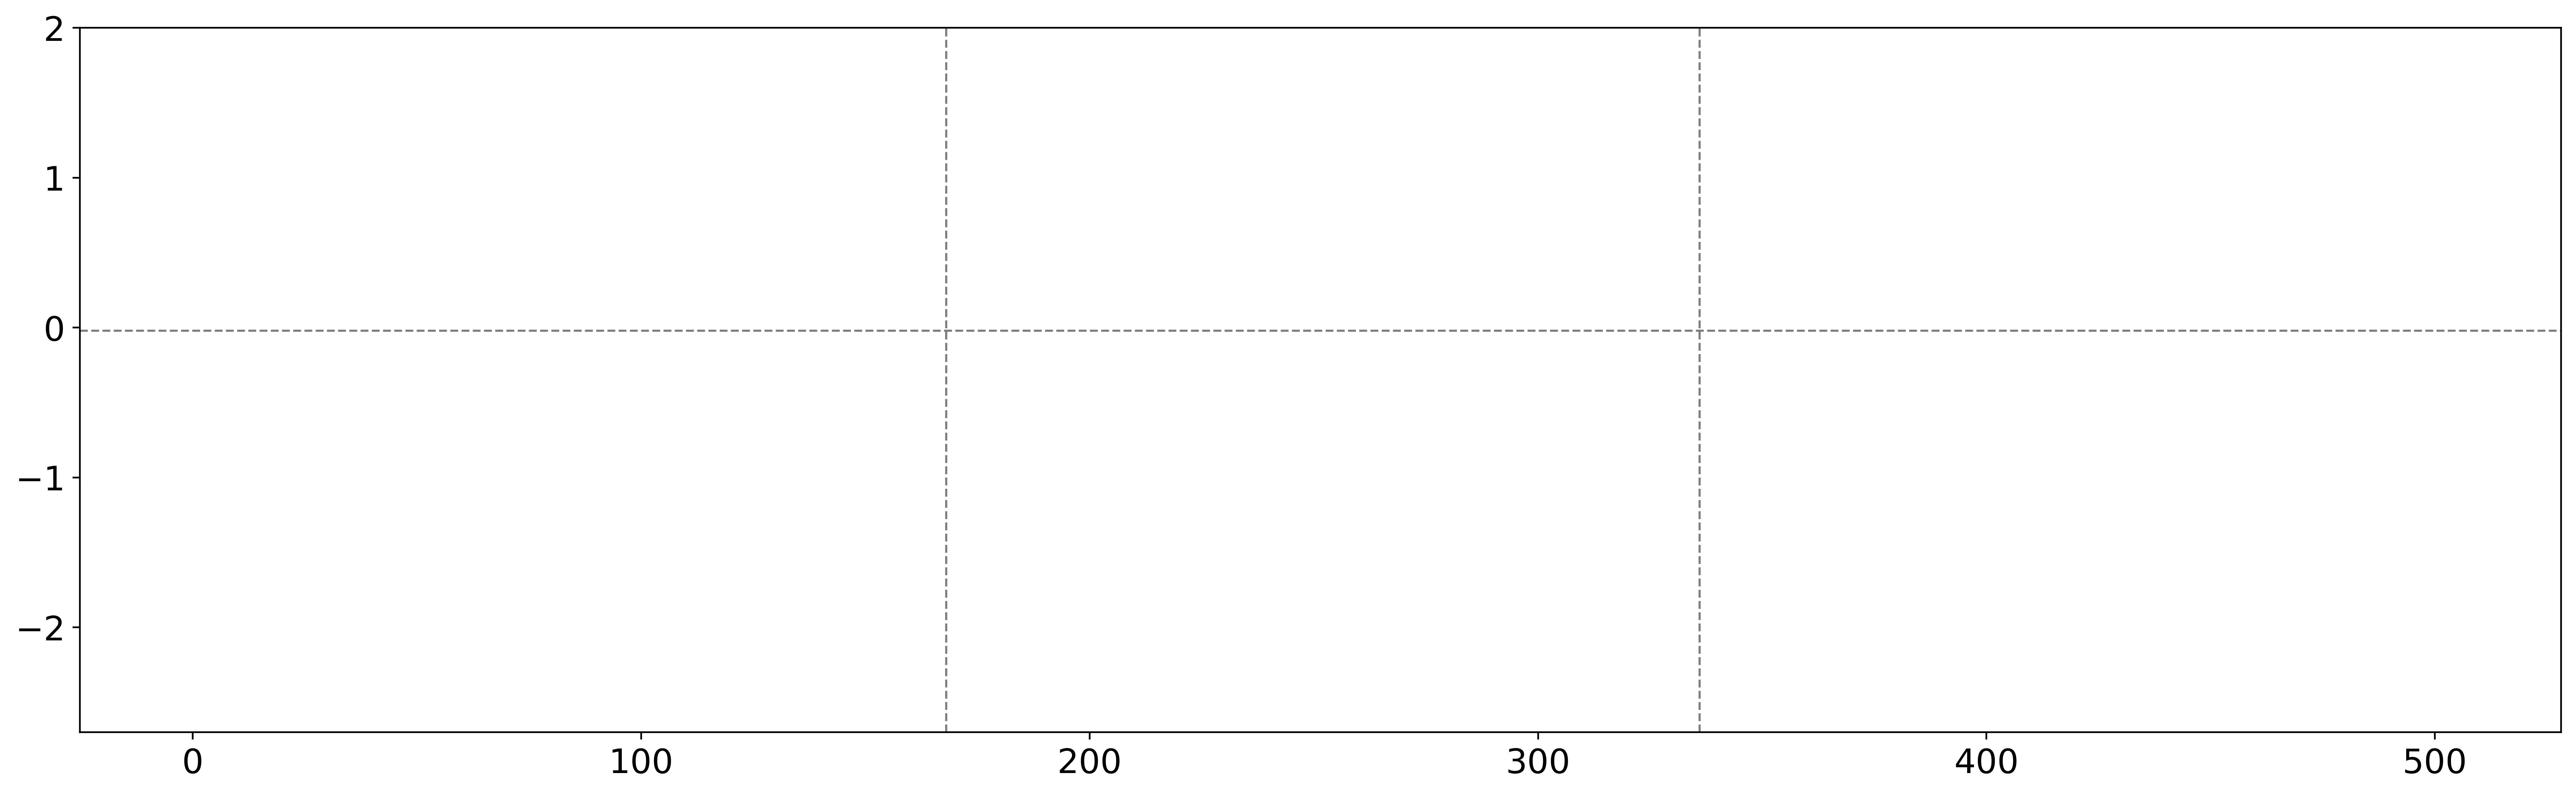

{'PNRMSE': 0.9196297696170674,
 'PNRMSE_predicted': 0.775574345913523,
 'CVRMSE': 0.45467716695698257,
 'CVRMSE_predicted': 0.3834542530210963,
 'MBE': -32.19466583964722,
 'MBE_predicted': -31.070126718545506}

In [ ]:
dft = reporting_pred.copy()
# dft = pred_baseline.copy()

seasons = {'winter': [11, 12, 1, 2], 'shoulder': [3, 4, 5, 10], 'summer': [6, 7, 8, 9]}
dft['season'] = dft.index.month
dft['season'] = dft['season'].apply(lambda x: 'winter' if x in seasons['winter'] else ('shoulder' if x in seasons['shoulder'] else 'summer'))
dft['season'] = dft['season'].astype('category')

dft['hour_of_week'] = dft.index.dayofweek*24 + dft.index.hour
dft['hour_of_week'] = dft['hour_of_week'].astype('category')

dft['hour'] = dft.index.hour
dft['hour'] = dft['hour'].astype('category')

# plot two weeks of data for oeem , new_model and observed
start = 24*0
pltwindow = 24*7
end = start + pltwindow

plt.rcParams["figure.figsize"] = (21,6)
# higher dpi for better quality
plt.rcParams['figure.dpi'] = 500
#x axis as hours
# plt.plot(dft['start_local'][start:end], label='start_local', linestyle='--')
# plt.plot(dft['observed'][start:end].values, label='observed', linewidth=2.5)

plt.plot(dft.groupby(['season', 'hour_of_week'])['observed'].mean().values, label='observed', linewidth=2.5)
# plt.plot(reporting_pred.groupby(['season', 'hour_of_week'])['model'].mean().values, label='CT',color='red',  linewidth=2.5)
plt.plot(dft.groupby(['season', 'hour_of_week'])['predicted'].mean().values, label='predicted', color='red', linewidth=4.5)

# plt.plot(-dft['ghi'][start:end].values*10, label='ghi', color='orange', linestyle='--', linewidth=1, alpha=0.7)
# plt.plot(dft['model'][start:end].values, label='oeem', color='green', linestyle='--', linewidth=1.5)
# plt.plot(dft['new_model'][start:end].values, label='new_model', color='mediumseagreen',linestyle='--', linewidth=4.5)

# plt.plot(dft['predicted'][start:end].values, label='new_model', color='red', linewidth=4.5)
# plt.plot(dft['temperature'][start:end].values/20, label='temperature', color='mediumseagreen', linewidth=1, alpha=0.7)
# make xtick and ytick labels larger
#add two vertical line in x=168 and x=336
plt.axvline(168, color='black', linewidth=1, linestyle='--' , alpha=0.5)
plt.axvline(336, color='black', linewidth=1, linestyle='--' , alpha=0.5)
plt.xticks(fontsize=16)
#change s tick to time
# plt.xticks(dft['start_local'].index[start:end].values, dft['start_local'].index[start:end].values, rotation=45)
plt.yticks(fontsize=16)
# transparent line on y=0
plt.axhline(-0.02, color='black', linewidth=1, linestyle='--' , alpha=0.5)

#make y axis the same for all plots
plt.ylim(-2.7, 2)
# plt.legend()
plt.show()


iqr = np.percentile(pred_baseline['observed'], 75) - np.percentile(pred_baseline['observed'], 25)
mn = np.mean(pred_baseline['observed'])

# get metrics both for model and predicted based on observed
metrics = {}
metrics['PNRMSE'] = PNRMSE(dft['observed'], dft['model'], iqr)
metrics['PNRMSE_predicted'] = PNRMSE(dft['observed'], dft['predicted'], iqr)
metrics['CVRMSE'] = CVRMSE(dft['observed'], dft['model'], mn)
metrics['CVRMSE_predicted'] = CVRMSE(dft['observed'], dft['predicted'], mn)
metrics['MBE'] = MBE(dft['observed'], dft['model'])
metrics['MBE_predicted'] = MBE(dft['observed'], dft['predicted'])

metrics

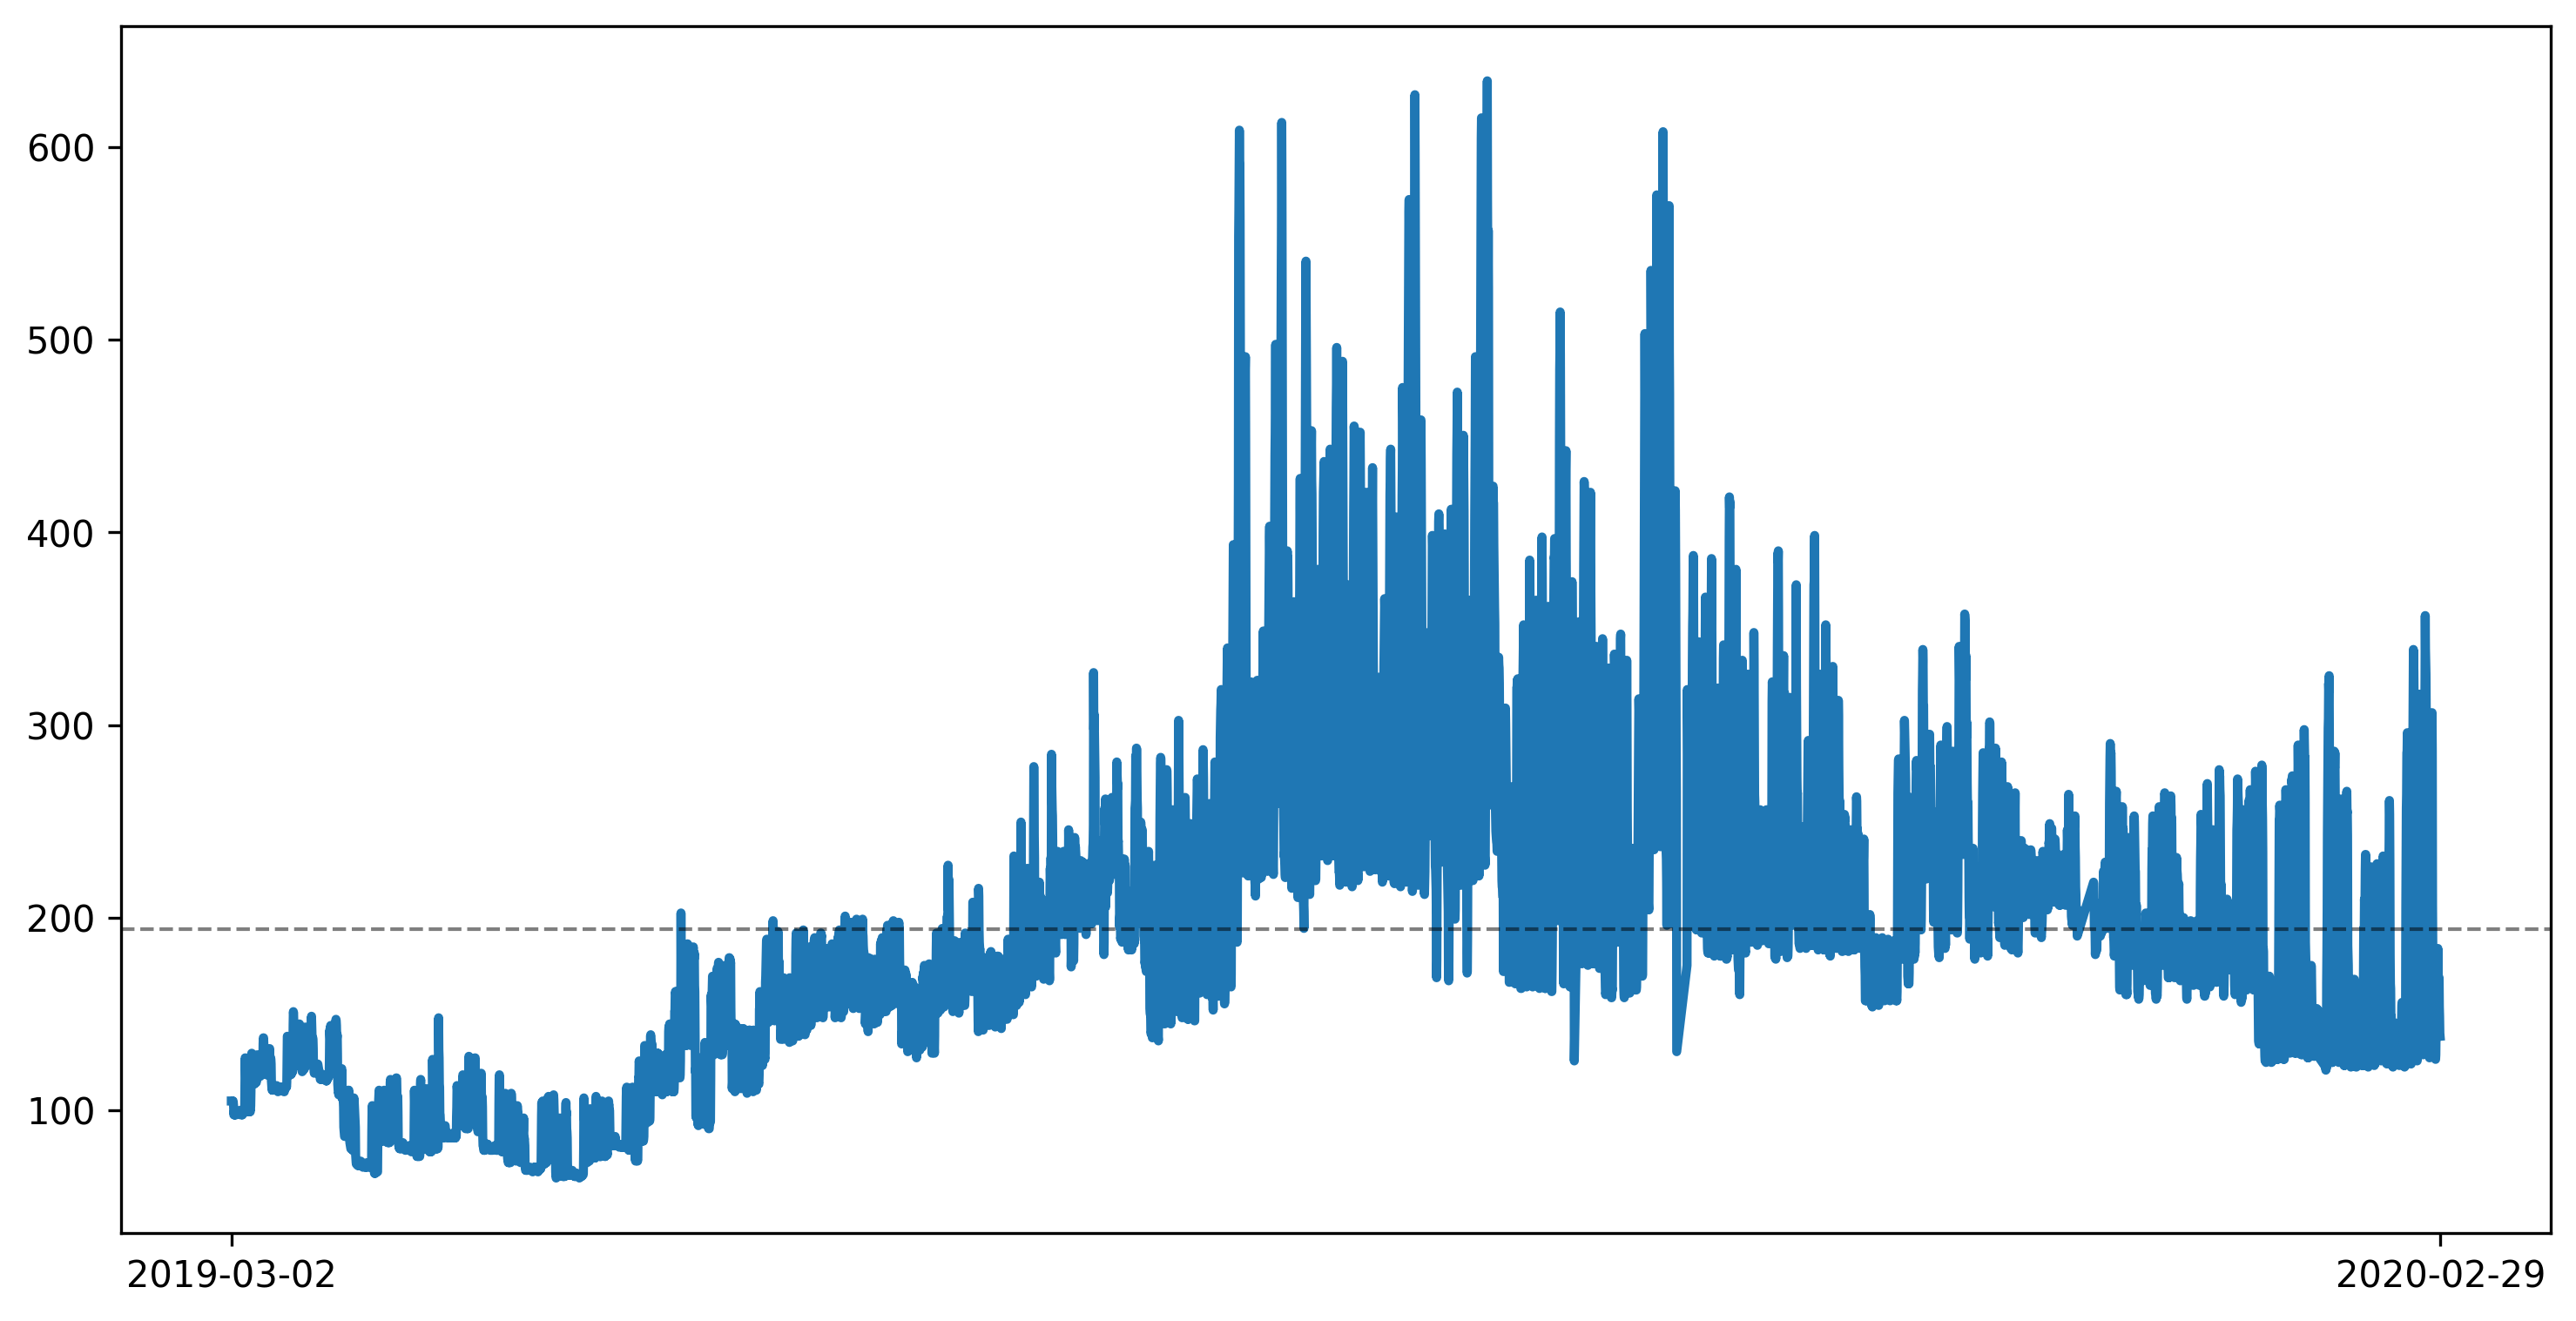

In [ ]:
# dft = reporting_pred.copy()
dft = pred_baseline.copy()
start = 24*0
pltwindow = -1
end = start + pltwindow
# get the rows between start and end
dft = dft.iloc[start:end]
plt.rcParams["figure.figsize"] = (12,6)
# higher dpi for better quality
plt.rcParams['figure.dpi'] = 300
#x axis as hours
# plt.plot(dft['start_local'][start:end], label='start_local', linestyle='--')
plt.plot(dft['observed'].values, label='observed', linewidth=2.5)


# plt.plot(-dft['ghi'].values*2, label='ghi', color='orange', linestyle='--', linewidth=1, alpha=0.7)
# plt.plot(dft['model'].values, label='oeem', color='green', linestyle='--', linewidth=1.5)
# plt.plot(dft['predicted'].values, label='new_model', color='red', linewidth=4.5)

# plt.plot(dft['predicted'][start:end].values, label='new_model', color='red', linewidth=4.5)
# plt.plot(dft['temperature'][start:end].values/20, label='temperature', color='mediumseagreen', linewidth=1, alpha=0.7)
# make xtick and ytick labels larger
#add two vertical line in x=168 and x=336
# plt.axvline(23, color='black', linewidth=1, linestyle='--' , alpha=0.5)
# plt.axvline(336, color='black', linewidth=1, linestyle='--' , alpha=0.5)
# plt.xticks(fontsize=16)
#change xtick to 1 to 48 and show every other 6 hours
# plt.xticks([0, 11, 23, 35, 47], [1, 12, 24, 36, 48])

# add the first and the last date to the xticks
first_date = dft.index[0].date()
last_date = dft.index[-1].date()
plt.xticks([0, len(dft['observed'])], [first_date, last_date])

# plt.yticks(fontsize=16)
# transparent line on y=0
plt.axhline(dft['observed'].mean(), color='black', linewidth=1, linestyle='--' , alpha=0.5)

#make y axis the same for all plots
# plt.ylim(-2.9, 2.9)
# plt.xlim(0, 47)
# plt.legend()
plt.show()

In [ ]:
# dft = pred_baseline.copy()
# dft['observed'].describe()
# idx = dft['observed'].argmin() -24*2
# print(idx)

# selected_date = dft.index[idx].date()
# # get the data for the selected date
# selected_data = dft[dft.index.date == selected_date]


1240


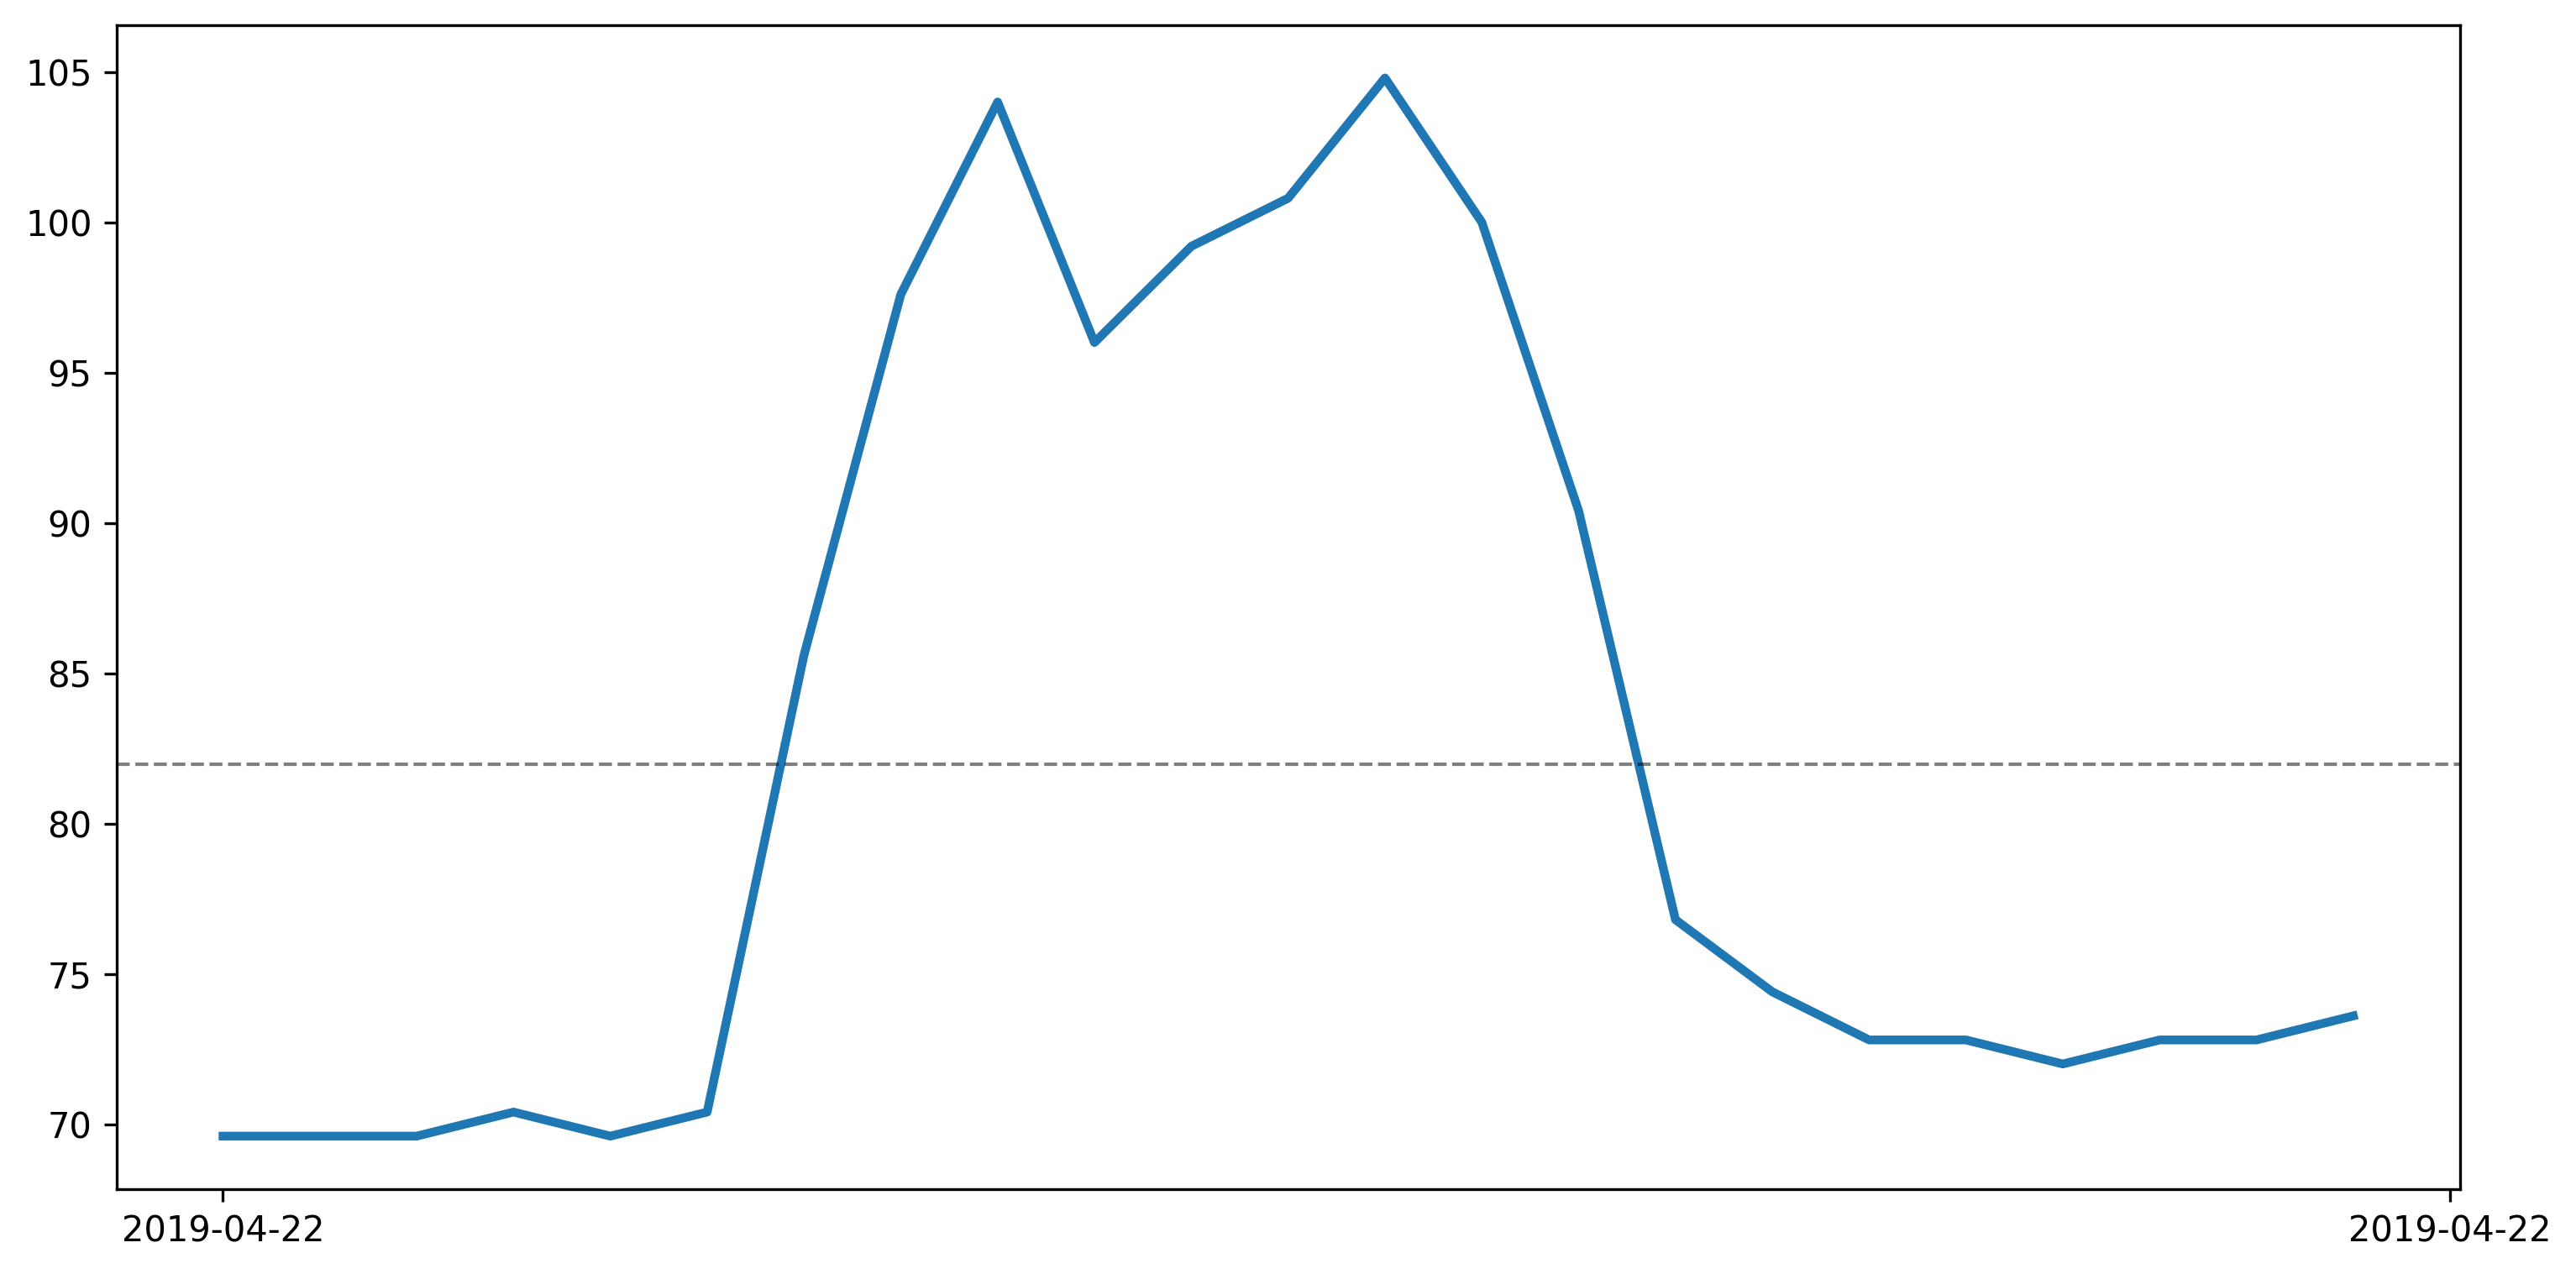

In [ ]:
start = 24*0
pltwindow = -1
end = start + pltwindow
dft = selected_data.copy()
dft = repo
# get the rows between start and end
dft = dft.iloc[start:end]
plt.rcParams["figure.figsize"] = (12,6)
# higher dpi for better quality
plt.rcParams['figure.dpi'] = 300
#x axis as hours
# plt.plot(dft['start_local'][start:end], label='start_local', linestyle='--')
plt.plot(dft['observed'].values, label='observed', linewidth=2.5)

#change xtick to 1 to 48 and show every other 6 hours
first_date = dft.index[0].date()
last_date = dft.index[-1].date()
plt.xticks([0, len(dft['observed'])], [first_date, last_date])


plt.axhline(dft['observed'].mean(), color='black', linewidth=1, linestyle='--' , alpha=0.5)

plt.show()

In [ ]:
634.4/208

3.05

In [ ]:
meta_meter

dpsm_model_id  \
dpsm_id                                                                         
None-9097391784_1-9097391784_1          None-9097391784_1-9097391784_1__covid   
None-9097391784_1-9097391784_1      None-9097391784_1-9097391784_1__pre_covid   
None-9097391784_1-9097391784_1  None-9097391784_1-9097391784_1__pre_pre_covid   

                                       cohort s_cust_cl_cd s_naics_group  \
dpsm_id                                                                    
None-9097391784_1-9097391784_1          covid      COM/IND       Offices   
None-9097391784_1-9097391784_1      pre_covid      COM/IND       Offices   
None-9097391784_1-9097391784_1  pre_pre_covid      COM/IND       Offices   

                                has_net   latitude   longitude  zip_code  \
dpsm_id                                                                    
None-9097391784_1-9097391784_1     True  37.991502 -122.286607     94564   
None-9097391784_1-9097391784_1     True  37.991502 -122.286607     94564   
None-9097391784_1-9097391784_1     True  37.991502 -122.286607     94564   

                               station_usaf_id  station_latitude  \
dpsm_id                                                            
None-9097391784_1-9097391784_1          724950            37.992   
None-9097391784_1-9097391784_1          724950            37.992   
None-9097391784_1-9097391784_1          724950            37.992   

                                station_longitude station_ca_climate_zone  \
dpsm_id                                                                     
None-9097391784_1-9097391784_1           -122.055                   CA_12   
None-9097391784_1-9097391784_1           -122.055                   CA_12   
None-9097391784_1-9097391784_1           -122.055                   CA_12   

                                days_kept  hours_kept  
dpsm_id                                                
None-9097391784_1-9097391784_1        363        8593  
None-9097391784_1-9097391784_1        365        8614  
None-9097391784_1-9097391784_1         29         696

In [ ]:
reporting_pred

temperature    observed       model  solar_supp  ghi  \
datetime                                                                    
2020-03-01 00:00:00     49.34405  129.599998  108.136049         1.0  0.0   
2020-03-01 01:00:00     48.37145  128.000000  110.160731         1.0  0.0   
2020-03-01 02:00:00     47.37560  128.799999  112.343598         1.0  0.0   
2020-03-01 03:00:00     47.59070  128.000000  108.934107         1.0  0.0   
2020-03-01 04:00:00     48.01370  127.999999  105.573819         1.0  0.0   
...                          ...         ...         ...         ...  ...   
2021-03-31 20:00:00     69.97400  135.199999  111.509808         1.0  0.0   
2021-03-31 21:00:00     64.95185  134.399999   92.703606         1.0  0.0   
2021-03-31 22:00:00     61.75550  133.599998   89.702138         1.0  0.0   
2021-03-31 23:00:00     59.78705   98.399999   85.095917         1.0  0.0   
2021-04-01 00:00:00     58.98215   98.399999   91.821588         1.0  0.0   

                     clearsky_ghi  interpolated   predicted        date  \
datetime                                                                  
2020-03-01 00:00:00           0.0         False  131.694647  2020-03-01   
2020-03-01 01:00:00           0.0         False  131.777758  2020-03-01   
2020-03-01 02:00:00           0.0         False  132.124153  2020-03-01   
2020-03-01 03:00:00           0.0         False  132.133611  2020-03-01   
2020-03-01 04:00:00           0.0         False  132.414299  2020-03-01   
...                           ...           ...         ...         ...   
2021-03-31 20:00:00           0.0         False  161.494974  2021-03-31   
2021-03-31 21:00:00           0.0         False  156.913067  2021-03-31   
2021-03-31 22:00:00           0.0         False  153.232612  2021-03-31   
2021-03-31 23:00:00           0.0         False  148.890121  2021-03-31   
2021-04-01 00:00:00           0.0          True         NaN  2021-04-01   

                       season hour_of_week hour  
datetime                                         
2020-03-01 00:00:00  shoulder          144    0  
2020-03-01 01:00:00  shoulder          145    1  
2020-03-01 02:00:00  shoulder          146    2  
2020-03-01 03:00:00  shoulder          147    3  
2020-03-01 04:00:00  shoulder          148    4  
...                       ...          ...  ...  
2021-03-31 20:00:00  shoulder           68   20  
2021-03-31 21:00:00  shoulder           69   21  
2021-03-31 22:00:00  shoulder           70   22  
2021-03-31 23:00:00  shoulder           71   23  
2021-04-01 00:00:00  shoulder           72    0  

[9504 rows x 12 columns]

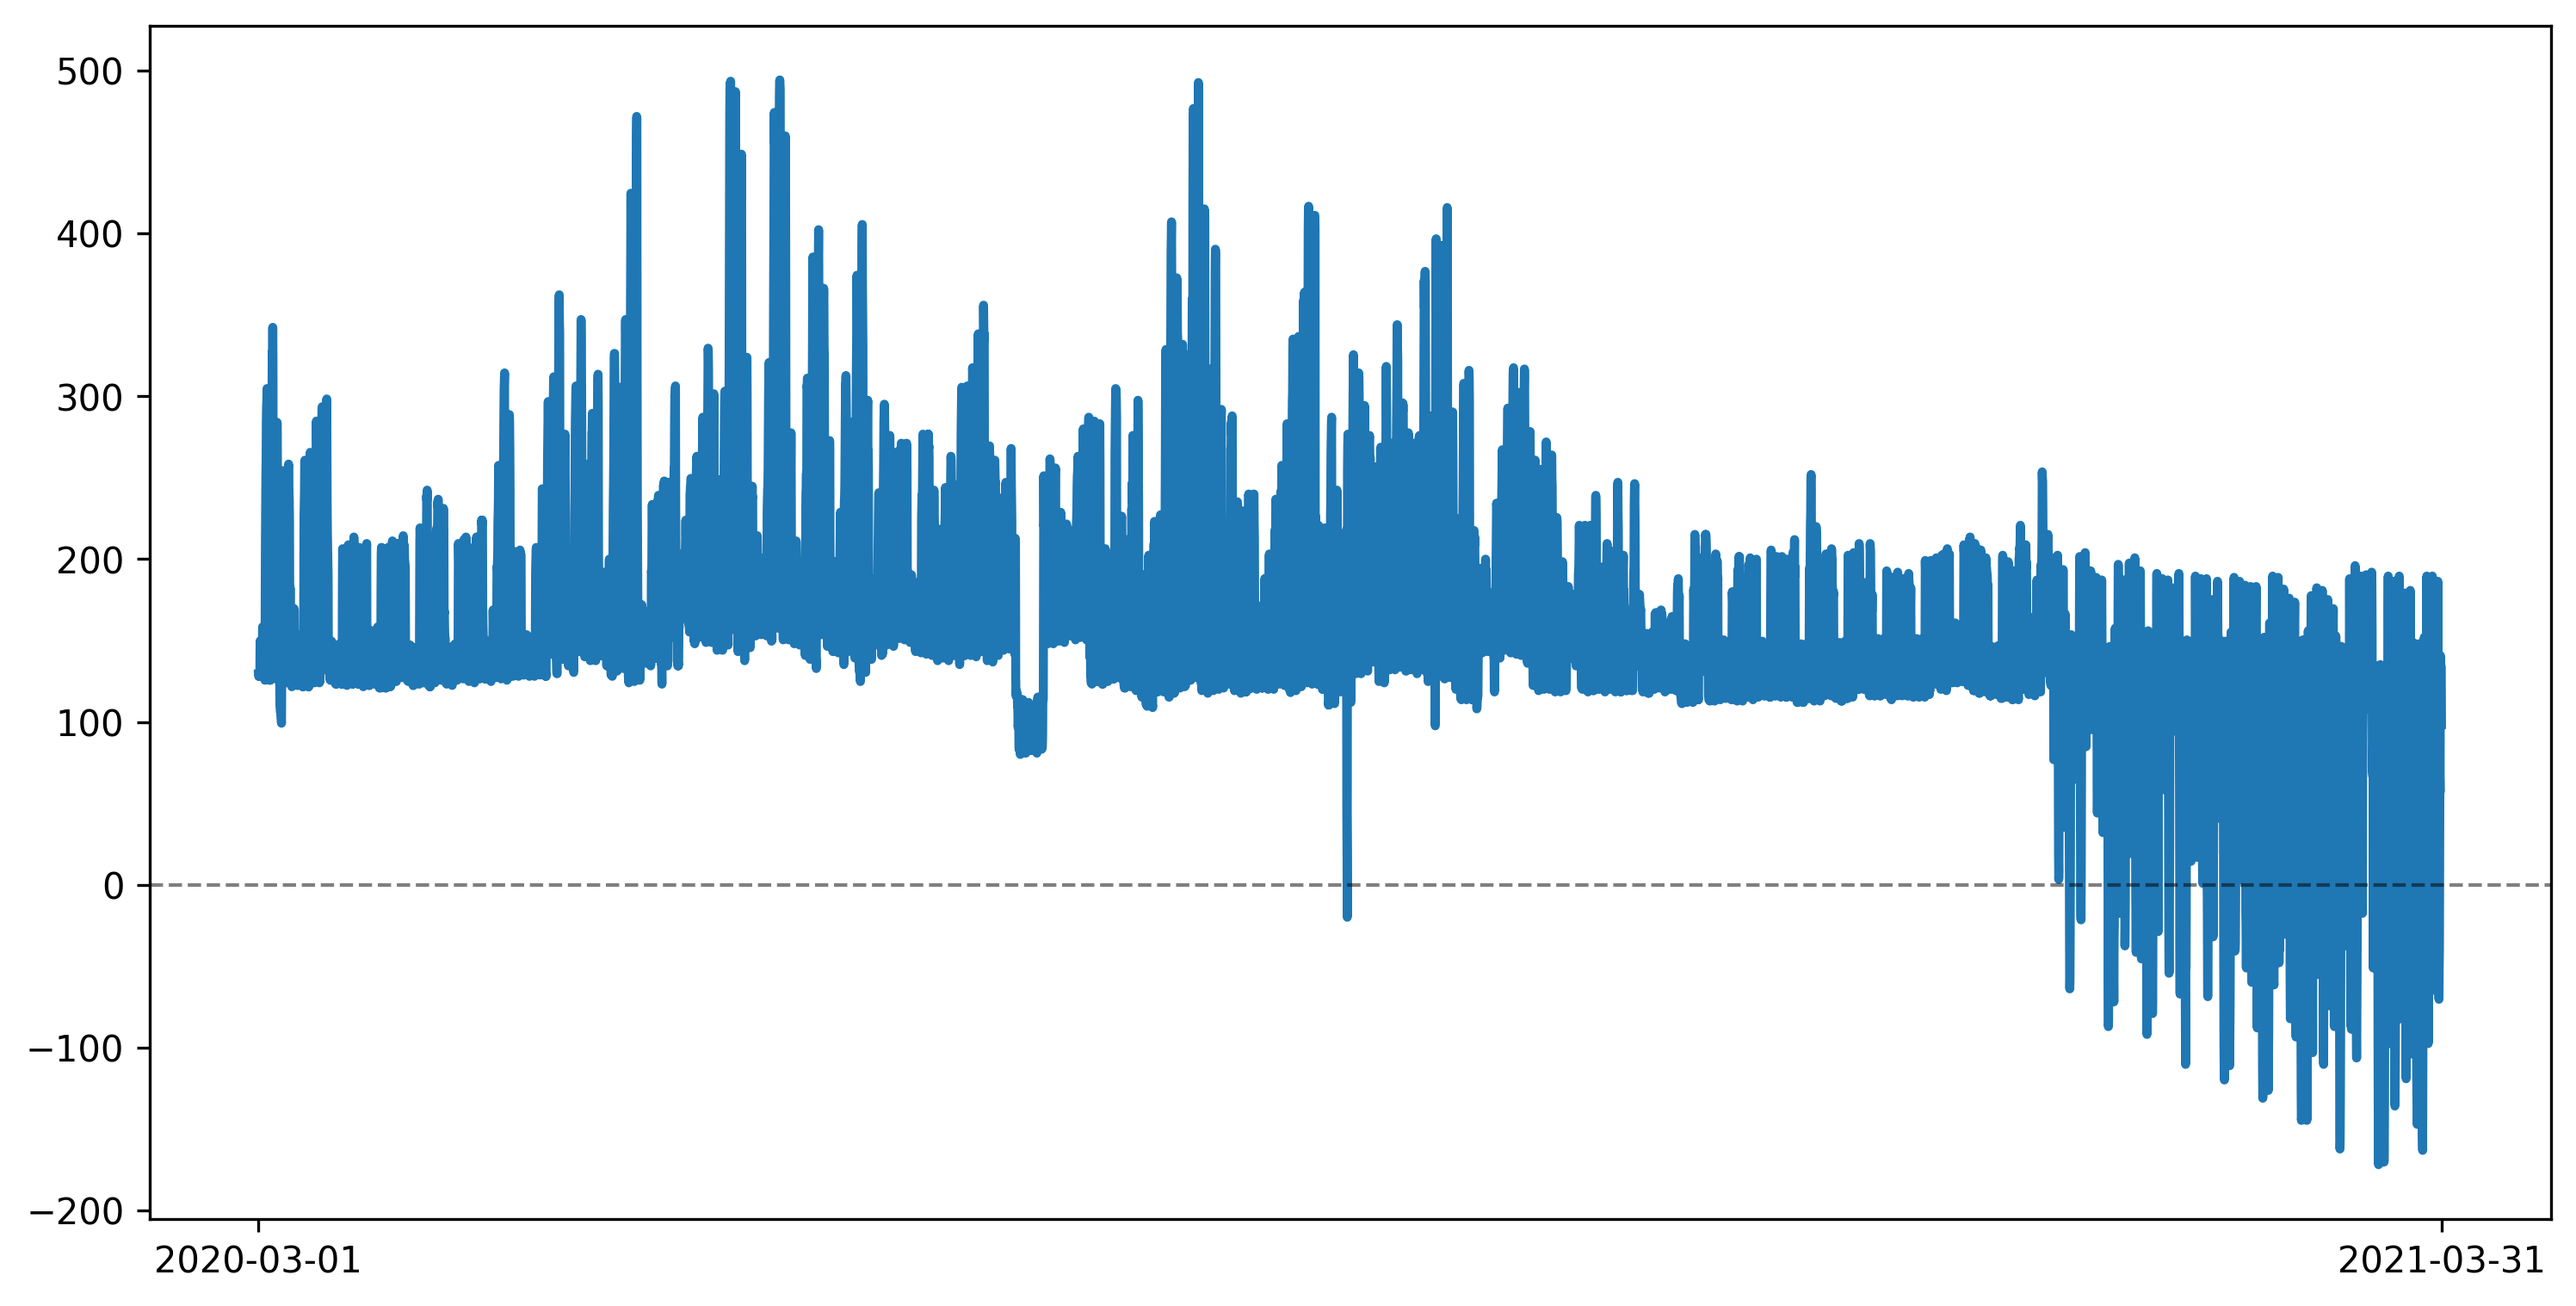

In [37]:
dft = reporting_pred.copy()
# dft = pred_baseline.copy()
start = 24*0
pltwindow = -1
end = start + pltwindow
# get the rows between start and end
dft = dft.iloc[start:end]
plt.rcParams["figure.figsize"] = (12,6)
# higher dpi for better quality
plt.rcParams['figure.dpi'] = 300
#x axis as hours
# plt.plot(dft['start_local'][start:end], label='start_local', linestyle='--')
plt.plot(dft['observed'].values, label='observed', linewidth=2.5)


# plt.plot(-dft['ghi'].values*2, label='ghi', color='orange', linestyle='--', linewidth=1, alpha=0.7)
# plt.plot(dft['model'].values, label='oeem', color='green', linestyle='--', linewidth=1.5)
# plt.plot(dft['predicted'].values, label='new_model', color='red', linewidth=4.5)

# plt.plot(dft['predicted'][start:end].values, label='new_model', color='red', linewidth=4.5)
# plt.plot(dft['temperature'][start:end].values/20, label='temperature', color='mediumseagreen', linewidth=1, alpha=0.7)
# make xtick and ytick labels larger
#add two vertical line in x=168 and x=336
# plt.axvline(23, color='black', linewidth=1, linestyle='--' , alpha=0.5)
# plt.axvline(336, color='black', linewidth=1, linestyle='--' , alpha=0.5)
# plt.xticks(fontsize=16)
#change xtick to 1 to 48 and show every other 6 hours
first_date = dft.index[0].date()
last_date = dft.index[-1].date()
plt.xticks([0, len(dft['observed'])], [first_date, last_date])


# plt.yticks(fontsize=16)
# transparent line on y=0
plt.axhline(0, color='black', linewidth=1, linestyle='--' , alpha=0.5)

#make y axis the same for all plots
# plt.ylim(-2.9, 2.9)
# plt.xlim(0, 47)
# plt.legend()
plt.show()

In [ ]:
reporting_pred.describe()

temperature     observed        model  solar_supp          ghi  \
count  9504.000000  9504.000000  9418.000000      9504.0  9504.000000   
mean     61.877841   160.453998   192.638539         1.0     0.222600   
std      13.469464    69.397191    79.977040         0.0     0.303603   
min      33.980000  -172.000000    70.817906         1.0     0.000000   
25%      51.974750   127.200000   133.360687         1.0     0.000000   
50%      60.084345   149.600000   182.661975         1.0     0.007000   
75%      69.844962   191.200000   226.505825         1.0     0.435250   
max     111.533900   494.400000   621.856708         1.0     1.049000   

       clearsky_ghi    predicted  
count   9504.000000  9336.000000  
mean       0.245365   191.664685  
std        0.319010    65.059412  
min        0.000000    58.473541  
25%        0.000000   148.813382  
50%        0.010000   176.828170  
75%        0.493000   217.544865  
max        1.049000   556.154166

In [38]:
# select reporting period after the intervention
selected = reporting_pred.loc[reporting_pred.index >= PV_interventation]
selected.describe()

temperature     observed        model  solar_supp          ghi  \
count  1680.000000  1680.000000  1680.000000      1680.0  1680.000000   
mean     53.211148    90.252857   151.170839         1.0     0.175900   
std       8.276649    76.746706    40.070890         0.0     0.257193   
min      33.980000  -172.000000    81.466911         1.0     0.000000   
25%      47.364050    65.400000   122.517735         1.0     0.000000   
50%      51.867050   118.400000   144.728159         1.0     0.000000   
75%      58.226300   135.999999   170.326826         1.0     0.317000   
max      82.033700   204.000000   367.356870         1.0     0.923000   

       clearsky_ghi    predicted  
count   1680.000000  1677.000000  
mean       0.207873   159.554708  
std        0.280812    34.951624  
min        0.000000    58.473541  
25%        0.000000   134.157505  
50%        0.000000   155.221653  
75%        0.453000   182.556215  
max        0.923000   300.408907